In [1]:
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import *
from keras.optimizers import *
from keras.models import Model
from keras.callbacks import *
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from joblib import Parallel, delayed

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### settings

In [2]:
save_dir = "./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/"

In [3]:
N_SPLITS = 5
MAX_THREADS = 8
N_TRAIN = 10
max_num = 127
min_num = -128
n_samples = 800000
sample_duration = 0.02
sample_rate = n_samples * (1 / sample_duration)

### process

In [4]:
df_train = pd.read_csv('../data/input/metadata_train.csv')
df_train = df_train.set_index(['id_measurement', 'phase'])

In [5]:
def get_features(dataset='train', split_parts=10):
    if dataset == 'train':
        cache_file = 'X.npy'
        meta_file = '../data/input/metadata_train.csv'
    elif dataset == 'test':
        cache_file = 'X_test.npy'
        meta_file = '../data/input/metadata_test.csv'

    meta_df = pd.read_csv(meta_file)

    data_measurements = meta_df.pivot(
        index='id_measurement', columns='phase', values='signal_id'
    )
    data_measurements = data_measurements.values
    data_measurements = np.array_split(data_measurements, split_parts, axis=0)
    X = Parallel(n_jobs=min(split_parts, MAX_THREADS), verbose=1)(delayed(prep_data)(p, dataset) for p in data_measurements)
    X = np.concatenate(X, axis=0)

    if dataset == 'train':
        # y = meta_df.loc[meta_df['phase']==0, 'target'].values
        # y = meta_df.groupby("id_measurement")["target"].max().sort_index().values
        y = meta_df.groupby("id_measurement")["target"].sum().values
        y[y < 2] = 0
        y[y >= 2] = 1

        np.save(save_dir + "X.npy", X)
        np.save(save_dir + "y.npy", y)
    elif dataset == 'test':
        y = None
        np.save(save_dir + "X_test.npy", X)

    return X, y

In [6]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [7]:
def prep_data(signal_ids, dataset="train"):
    signal_ids_all = np.concatenate(signal_ids)
    if dataset == "train":
        praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    elif dataset == "test":
        praq_data = pq.read_pandas('../data/input/test.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    else:
        raise ValueError("Unknown dataset")
    X = []
    for sids in signal_ids:
        data = praq_data[[str(s) for s in sids]].values.T
        X_signal = [transform_ts(signal) for signal in data]
        X_signal = np.concatenate(X_signal, axis=1)
        X.append(X_signal)
    X = np.asarray(X)
    return X

In [8]:
from scipy.signal import butter, sosfilt
import pywt

n_samples = 800000
sample_duration = 0.02
sample_rate = n_samples * (1 / sample_duration)

def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = sosfilt(sos, x)
    return filtered_sig

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per" )
    for lev in range(1, len(coeff)):
        uthresh = (1/0.6745) * maddest(np.abs(coeff[-lev])) * np.sqrt( 2*np.log(len(x)) )
        coeff[-lev] = pywt.threshold(coeff[-lev], value=uthresh, mode='hard')
    return pywt.waverec(coeff, wavelet, mode='per')

In [266]:
from scipy.signal import butter, sosfilt, find_peaks, peak_prominences
import pywt
import tsfresh
distance = 50

def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    # setting
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []

    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    ts_std = high_pass_filter(ts_std, low_cutoff=10000)
    ts_std = denoise_signal(ts_std)

    for i in range(0, sample_size, bucket_size):
        ts_range = ts_std[i:i + bucket_size]
        std = ts_range.std()
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 75, 99, 100])
        max_range = percentil_calc[-1] - percentil_calc[0]

        pos_peaks, _ = find_peaks(ts_range, distance=distance)
        neg_peaks, _ = find_peaks(ts_range*-1, distance=distance)
        widths = np.diff(pos_peaks)
        prominences = peak_prominences(ts_range, pos_peaks)[0]

        peak_result = {
            'pos_peak_count': pos_peaks.size / 160,
            'peak_count_buchet': (pos_peaks.size + neg_peaks.size) / 160,
            'width_mean_buchet': (widths.mean() / bucket_size if widths.size else 1.) - 1,
            'width_max_buchet': (widths.max() / bucket_size if widths.size else 1.) - 1,
            'width_min_buchet': (widths.min() / bucket_size if widths.size else 1.) - 1,
            'prominence_mean_buchet': prominences.mean() / 2 if prominences.size else 0.,
            'prominence_max_buchet': prominences.max() / 2 if prominences.size else 0.,
            'prominence_min_buchet': prominences.min() / 2 if prominences.size else 0.,
        }
        peak_result = np.array(list(peak_result.values())).astype(float)       

        # complexity
        fe_cid_ce = tsfresh.feature_extraction.feature_calculators.cid_ce(ts_range, normalize=False)
        fe_cid_ce = np.clip(fe_cid_ce, 0, 1)
        """
        fe_katz_fd = katz_fd(ts_range) - 1
        fe_perm_entropy = perm_entropy(ts_range)
        fe_svd_entropy = svd_entropy(ts_range)
        """

        new_ts.append(np.concatenate([
            np.asarray([fe_cid_ce]),
            peak_result, 
            np.asarray([std, max_range]),
            percentil_calc
        ]))
        
    return np.asarray(new_ts)

In [267]:
X, y = get_features("train", split_parts=32)
print(X.shape, y.shape)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:  4.8min finished


(2904, 160, 51) (2904,)


In [4]:
X = np.load(save_dir + "X.npy")
y = np.load(save_dir + "y.npy")
print(X.shape, y.shape)

(2904, 160, 51) (2904,)


In [269]:
%%time
meta_test = pd.read_csv('../data/input/metadata_test.csv')
meta_test = meta_test.set_index(['signal_id'])
X_test_input, _ = get_features("test", split_parts=16)
X_test_input.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed: 10.3min finished


CPU times: user 1.34 s, sys: 2.23 s, total: 3.57 s
Wall time: 10min 23s


In [5]:
X_test_input = np.load(save_dir + "X_test.npy")
print(X_test_input.shape)

(6779, 160, 51)


### set model

In [6]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [7]:
def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    
    return model

In [8]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

### train adversal validation

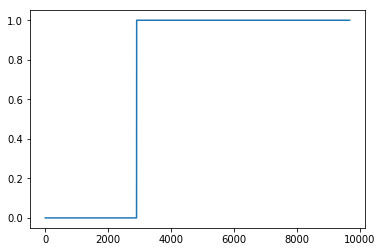

((9683, 160, 51), (9683,), 6779.0)

In [10]:
X_total = np.concatenate((X, X_test_input))
y_total = np.ones(len(X_total))
y_total[:len(X)] = 0

plt.plot(y_total)
plt.show()
X_total.shape, y_total.shape, y_total.sum()

In [11]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)), str(round(roc_val,4))), end=100*' '+'\n')
        logs['val_auc'] = roc_val
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [12]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_total, y_total))
preds_val = []
y_val = []

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X_total[train_idx], y_total[train_idx], X_total[val_idx], y_total[val_idx]
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    ckpt = ModelCheckpoint(
        save_dir + 'weights_{}.h5'.format(idx), save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_auc', mode='max'
    )
    roc_auc = roc_callback(training_data=(train_X, train_y), validation_data=(val_X, val_y))
    early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode="max")

    model.fit(
        train_X, train_y, batch_size=128, epochs=100,
        validation_data=[val_X, val_y], callbacks=[roc_auc, ckpt, early_stopping]
    )
    
    model.load_weights(save_dir + 'weights_{}.h5'.format(idx))
    preds_val.append(model.predict(val_X, batch_size=512))
    y_val.append(val_y)

preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 7746 samples, validate on 1937 samples
Epoch 1/100
7746/7746 [==============================] - 6s 785us/step - loss: 0.6154 - val_loss: 0.6129
roc-auc: 0.5302 - roc-auc_val: 0.5012                                                                                                    

Epoch 00001: val_auc improved from -inf to 0.50124, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_0.h5
Epoch 2/100
7746/7746 [==============================] - 3s 397us/step - loss: 0.6086 - val_loss: 0.6008
roc-auc: 0.5895 - roc-auc_val: 0.5885                                                                                                    

Epoch 00002: val_auc improved from 0.50124 to 0.58845, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_0.h5
Epoch 3/100
7746/7746 [==============================] - 3s 403us/step - loss: 0.6018 - val_loss: 0.5946
roc-auc: 0.629 - roc-auc_val: 0.6412                                 

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, preds_val)

In [ ]:
target = np.ones(len(X_total))
target = target * -1
target[:len(y)] = y
target.shape, target[target != -1].sum(), y.sum()

In [ ]:
val_idx_list = []
for idx, (train_idx, val_idx) in enumerate(splits):
    val_idx_list.append(val_idx)
val_idx_list = np.concatenate(val_idx_list)

In [ ]:
result = []
for idx, preds, test_flg in zip(val_idx_list, preds_val, y_val):
    result.append((idx, preds, test_flg))

result = pd.DataFrame(result, columns=["idx", "preds", "test_flg"])
result = result.sort_values("idx").reset_index(drop=True)
result["target"] = target
result.head()

In [ ]:
# check
print(result.query("test_flg == 0").target.sum())
result[["target", "test_flg"]].plot()
plt.show()
result.query("test_flg == 0").preds.hist()
plt.show()
result.query("test_flg == 1").preds.hist()
plt.show()

In [ ]:
result.to_csv(save_dir + "adversarial_validation_result.csv", index=False, header=True)

### get adversal validation result

In [9]:
#ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_result = pd.read_csv("./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0")
print(ad_train.test_flg.sum(), ad_train.target.sum(), y.sum())
ad_train.head()

0.0 175.0 175


,idx,preds,test_flg,target
0,0,0.118761,0.0,0.0
1,1,0.403666,0.0,1.0
2,2,0.005546,0.0,0.0
3,3,0.003310,0.0,0.0
4,4,0.002331,0.0,0.0


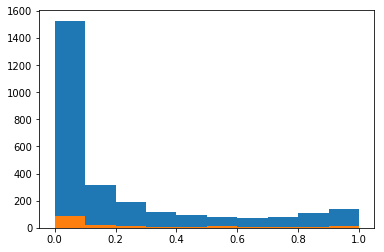

In [10]:
plt.hist(ad_train.query("target == 0")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.hist(ad_train.query("target == 1")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.show()

In [11]:
# cut adversarial probabilities (for train) in 5 buckets
adver_idx_08_to_1 = ad_train.query("preds >= 0.80").idx.tolist()
adver_idx_06_to_08 = ad_train.query("0.80 > preds >= 0.60").idx.tolist()
adver_idx_04_to_06 = ad_train.query("0.60 > preds >= 0.40").idx.tolist()
adver_idx_02_to_04 = ad_train.query("0.40 > preds >= 0.20").idx.tolist()
adver_idx_00_to_02 = ad_train.query("0.20 > preds >= 0.00").idx.tolist()

print(len(adver_idx_08_to_1), len(adver_idx_06_to_08), len(adver_idx_04_to_06), len(adver_idx_02_to_04), len(adver_idx_00_to_02))
print(len(adver_idx_08_to_1)+len(adver_idx_06_to_08)+len(adver_idx_04_to_06)+len(adver_idx_02_to_04)+len(adver_idx_00_to_02))
print(len(y))

print(y[adver_idx_08_to_1].sum(), y[adver_idx_06_to_08].sum(), y[adver_idx_04_to_06].sum(), y[adver_idx_02_to_04].sum(), y[adver_idx_00_to_02].sum())
print(y[adver_idx_08_to_1].sum()+y[adver_idx_06_to_08].sum()+y[adver_idx_04_to_06].sum()+y[adver_idx_02_to_04].sum()+y[adver_idx_00_to_02].sum())
print(y.sum())

263 168 192 327 1954
2904
2904
20 12 16 17 110
175
175


In [12]:
adver_idx_08_to_1_pos = ad_train.query("preds >= 0.80 & target == 1").idx.tolist()
adver_idx_06_to_08_pos = ad_train.query("0.80 > preds >= 0.60 & target == 1").idx.tolist()
adver_idx_04_to_06_pos = ad_train.query("0.60 > preds >= 0.40 & target == 1").idx.tolist()
adver_idx_02_to_04_pos = ad_train.query("0.40 > preds >= 0.20 & target == 1").idx.tolist()
adver_idx_00_to_02_pos = ad_train.query("0.20 > preds >= 0.00 & target == 1").idx.tolist()

print(len(adver_idx_08_to_1_pos), len(adver_idx_06_to_08_pos), len(adver_idx_04_to_06_pos), len(adver_idx_02_to_04_pos), len(adver_idx_00_to_02_pos))
print(len(adver_idx_08_to_1_pos)+len(adver_idx_06_to_08_pos)+len(adver_idx_04_to_06_pos)+len(adver_idx_02_to_04_pos)+len(adver_idx_00_to_02_pos))
print(len(y))

20 12 16 17 110
175
2904


In [13]:
fold_index = np.zeros(len(y))
fold_index[adver_idx_08_to_1] = 1
fold_index[adver_idx_08_to_1_pos] = 2
fold_index[adver_idx_06_to_08] = 3
fold_index[adver_idx_06_to_08_pos] = 4
fold_index[adver_idx_04_to_06] = 5
fold_index[adver_idx_04_to_06_pos] = 6
fold_index[adver_idx_02_to_04] = 7
fold_index[adver_idx_02_to_04_pos] = 8
fold_index[adver_idx_00_to_02] = 9
fold_index[adver_idx_00_to_02_pos] = 10

print(len(fold_index[fold_index==1]), len(fold_index[fold_index==2]), len(fold_index[fold_index==1])+len(fold_index[fold_index==2]))
print(len(fold_index[fold_index==3]), len(fold_index[fold_index==4]), len(fold_index[fold_index==3])+len(fold_index[fold_index==4]))
print(len(fold_index[fold_index==5]), len(fold_index[fold_index==6]), len(fold_index[fold_index==5])+len(fold_index[fold_index==6]))
print(len(fold_index[fold_index==7]), len(fold_index[fold_index==8]), len(fold_index[fold_index==7])+len(fold_index[fold_index==8]))
print(len(fold_index[fold_index==9]), len(fold_index[fold_index==10]), len(fold_index[fold_index==9])+len(fold_index[fold_index==10]))

243 20 263
156 12 168
176 16 192
310 17 327
1844 110 1954


### train

In [14]:
best_thr_list = []
best_score_list = []
preds_val_list = []

def threshold_search(y_true, y_proba):
    thresholds = np.linspace(0.0, 1.0, 101)
    scores = [matthews_corrcoef(y_true, (y_proba > t).astype(np.uint8)) for t in thresholds]
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

In [15]:
def train_per_fold(n_train, idx, train_X, train_y, val_X, val_y):
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[matthews_correlation])
    save_model_name = f'weights_{n_train}_{idx}.h5'
    ckpt = ModelCheckpoint(
        save_dir + save_model_name, save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max'
    )    
    model.fit(
        train_X, train_y, batch_size=128, epochs=50, verbose=1,
        validation_data=[val_X, val_y], callbacks=[ckpt]
    )

    model.load_weights(save_dir + save_model_name)
    preds_train = np.squeeze(model.predict(train_X, batch_size=512))
    preds_val = np.squeeze(model.predict(val_X, batch_size=512))
    preds_test = np.squeeze(model.predict(X_test_input, batch_size=300, verbose=1))

    return preds_train, preds_val, preds_test

In [16]:
splits = list(StratifiedKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        K.clear_session()
        print("Beginning fold {}".format(idx+1))
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]        
        preds_train, preds_val, preds_test = train_per_fold(n_train, idx, train_X, train_y, val_X, val_y)
        np.save(save_dir + f"preds_train_{n_train}_{idx}.npy", preds_train)
        np.save(save_dir + f"preds_val_{n_train}_{idx}.npy", preds_val)
        np.save(save_dir + f"preds_test_{n_train}_{idx}.npy", preds_test)

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))

===== n_train = 0 =====
Beginning fold 1
Train on 2319 samples, validate on 585 samples
Epoch 1/50
2319/2319 [==============================] - 38s 16ms/step - loss: 0.3231 - matthews_correlation: -0.0071 - val_loss: 0.2379 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_0_0.h5
Epoch 2/50
2319/2319 [==============================] - 1s 493us/step - loss: 0.2202 - matthews_correlation: 0.0000e+00 - val_loss: 0.2124 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2319/2319 [==============================] - 1s 490us/step - loss: 0.1695 - matthews_correlation: 0.0204 - val_loss: 0.1526 - val_matthews_correlation: 0.3607

Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.36067, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_0_0.h5
Epoch 4/

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.5, 0.6995095987082113)
val result: (0.48, 0.7365323413840272)
Beginning fold 2
Train on 2322 samples, validate on 582 samples
Epoch 1/50
2322/2322 [==============================] - 2s 960us/step - loss: 0.2899 - matthews_correlation: 0.0000e+00 - val_loss: 0.2255 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_0_1.h5
Epoch 2/50
2322/2322 [==============================] - 1s 471us/step - loss: 0.1893 - matthews_correlation: 0.0088 - val_loss: 0.1955 - val_matthews_correlation: 0.2116

Epoch 00002: val_matthews_correlation improved from 0.00000 to 0.21162, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_0_1.h5
Epoch 3/50
2322/2322 [==============================] - 1s 474us/step - loss: 0.1866 - matthews_correlation: 0.2736 - val_loss: 0.1925 - val_matthews_correlation: 0.0507

Epoch 00003: val_matthews


Epoch 00031: val_matthews_correlation did not improve from 0.64732
Epoch 32/50
2322/2322 [==============================] - 1s 485us/step - loss: 0.0791 - matthews_correlation: 0.6572 - val_loss: 0.1257 - val_matthews_correlation: 0.6065

Epoch 00032: val_matthews_correlation did not improve from 0.64732
Epoch 33/50
2322/2322 [==============================] - 1s 496us/step - loss: 0.0773 - matthews_correlation: 0.7039 - val_loss: 0.1194 - val_matthews_correlation: 0.6241

Epoch 00033: val_matthews_correlation did not improve from 0.64732
Epoch 34/50
2322/2322 [==============================] - 1s 458us/step - loss: 0.0790 - matthews_correlation: 0.6652 - val_loss: 0.1129 - val_matthews_correlation: 0.6164

Epoch 00034: val_matthews_correlation did not improve from 0.64732
Epoch 35/50
2322/2322 [==============================] - 1s 462us/step - loss: 0.0793 - matthews_correlation: 0.6925 - val_loss: 0.1163 - val_matthews_correlation: 0.5986

Epoch 00035: val_matthews_correlation did n


Epoch 00012: val_matthews_correlation did not improve from 0.66171
Epoch 13/50
2324/2324 [==============================] - 1s 479us/step - loss: 0.1066 - matthews_correlation: 0.6544 - val_loss: 0.0988 - val_matthews_correlation: 0.4398

Epoch 00013: val_matthews_correlation did not improve from 0.66171
Epoch 14/50
2324/2324 [==============================] - 1s 492us/step - loss: 0.0956 - matthews_correlation: 0.6096 - val_loss: 0.1066 - val_matthews_correlation: 0.6442

Epoch 00014: val_matthews_correlation did not improve from 0.66171
Epoch 15/50
2324/2324 [==============================] - 1s 497us/step - loss: 0.1036 - matthews_correlation: 0.5935 - val_loss: 0.1221 - val_matthews_correlation: 0.4398

Epoch 00015: val_matthews_correlation did not improve from 0.66171
Epoch 16/50
2324/2324 [==============================] - 1s 490us/step - loss: 0.0914 - matthews_correlation: 0.6453 - val_loss: 0.0976 - val_matthews_correlation: 0.4830

Epoch 00016: val_matthews_correlation did n

2324/2324 [==============================] - 1s 478us/step - loss: 0.0697 - matthews_correlation: 0.7105 - val_loss: 0.0818 - val_matthews_correlation: 0.6964

Epoch 00046: val_matthews_correlation did not improve from 0.73622
Epoch 47/50
2324/2324 [==============================] - 1s 482us/step - loss: 0.0849 - matthews_correlation: 0.6716 - val_loss: 0.1198 - val_matthews_correlation: 0.6571

Epoch 00047: val_matthews_correlation did not improve from 0.73622
Epoch 48/50
2324/2324 [==============================] - 1s 451us/step - loss: 0.0757 - matthews_correlation: 0.7281 - val_loss: 0.0830 - val_matthews_correlation: 0.7725

Epoch 00048: val_matthews_correlation improved from 0.73622 to 0.77247, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_0_2.h5
Epoch 49/50
2324/2324 [==============================] - 1s 474us/step - loss: 0.0751 - matthews_correlation: 0.7245 - val_loss: 0.1026 - val_matthews_correlation: 0.6433

Epoch 00049: val_matthews_correla

2326/2326 [==============================] - 1s 478us/step - loss: 0.1067 - matthews_correlation: 0.5966 - val_loss: 0.0874 - val_matthews_correlation: 0.8007

Epoch 00007: val_matthews_correlation improved from 0.78742 to 0.80070, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_0_4.h5
Epoch 8/50
2326/2326 [==============================] - 1s 491us/step - loss: 0.1051 - matthews_correlation: 0.5457 - val_loss: 0.1135 - val_matthews_correlation: 0.6686

Epoch 00008: val_matthews_correlation did not improve from 0.80070
Epoch 9/50
2326/2326 [==============================] - 1s 488us/step - loss: 0.1138 - matthews_correlation: 0.5383 - val_loss: 0.0884 - val_matthews_correlation: 0.7053

Epoch 00009: val_matthews_correlation did not improve from 0.80070
Epoch 10/50
2326/2326 [==============================] - 1s 496us/step - loss: 0.1089 - matthews_correlation: 0.5807 - val_loss: 0.0831 - val_matthews_correlation: 0.6987

Epoch 00010: val_matthews_correlati

2326/2326 [==============================] - 1s 475us/step - loss: 0.0854 - matthews_correlation: 0.6903 - val_loss: 0.0749 - val_matthews_correlation: 0.7143

Epoch 00041: val_matthews_correlation did not improve from 0.80070
Epoch 42/50
2326/2326 [==============================] - 1s 466us/step - loss: 0.0810 - matthews_correlation: 0.7117 - val_loss: 0.0941 - val_matthews_correlation: 0.5269

Epoch 00042: val_matthews_correlation did not improve from 0.80070
Epoch 43/50
2326/2326 [==============================] - 1s 489us/step - loss: 0.0869 - matthews_correlation: 0.5321 - val_loss: 0.0808 - val_matthews_correlation: 0.7051

Epoch 00043: val_matthews_correlation did not improve from 0.80070
Epoch 44/50
2326/2326 [==============================] - 1s 481us/step - loss: 0.0769 - matthews_correlation: 0.7257 - val_loss: 0.0838 - val_matthews_correlation: 0.7221

Epoch 00044: val_matthews_correlation did not improve from 0.80070
Epoch 45/50
2326/2326 [==============================] -

2319/2319 [==============================] - 1s 468us/step - loss: 0.0939 - matthews_correlation: 0.6245 - val_loss: 0.1079 - val_matthews_correlation: 0.6861

Epoch 00021: val_matthews_correlation did not improve from 0.71716
Epoch 22/50
2319/2319 [==============================] - 1s 464us/step - loss: 0.0943 - matthews_correlation: 0.6217 - val_loss: 0.0946 - val_matthews_correlation: 0.7111

Epoch 00022: val_matthews_correlation did not improve from 0.71716
Epoch 23/50
2319/2319 [==============================] - 1s 456us/step - loss: 0.1087 - matthews_correlation: 0.6124 - val_loss: 0.0927 - val_matthews_correlation: 0.6950

Epoch 00023: val_matthews_correlation did not improve from 0.71716
Epoch 24/50
2319/2319 [==============================] - 1s 473us/step - loss: 0.0953 - matthews_correlation: 0.6382 - val_loss: 0.1043 - val_matthews_correlation: 0.6258

Epoch 00024: val_matthews_correlation did not improve from 0.71716
Epoch 25/50
2319/2319 [==============================] -

2322/2322 [==============================] - 1s 488us/step - loss: 0.1046 - matthews_correlation: 0.5413 - val_loss: 0.1369 - val_matthews_correlation: 0.5697

Epoch 00034: val_matthews_correlation did not improve from 0.64258
Epoch 35/50
2322/2322 [==============================] - 1s 466us/step - loss: 0.0993 - matthews_correlation: 0.6727 - val_loss: 0.1227 - val_matthews_correlation: 0.4558

Epoch 00035: val_matthews_correlation did not improve from 0.64258
Epoch 36/50
2322/2322 [==============================] - 1s 493us/step - loss: 0.0929 - matthews_correlation: 0.5964 - val_loss: 0.1274 - val_matthews_correlation: 0.5737

Epoch 00036: val_matthews_correlation did not improve from 0.64258
Epoch 37/50
2322/2322 [==============================] - 1s 482us/step - loss: 0.1012 - matthews_correlation: 0.5994 - val_loss: 0.1200 - val_matthews_correlation: 0.4867

Epoch 00037: val_matthews_correlation did not improve from 0.64258
Epoch 38/50
2322/2322 [==============================] -


Epoch 00015: val_matthews_correlation did not improve from 0.65018
Epoch 16/50
2324/2324 [==============================] - 1s 435us/step - loss: 0.1053 - matthews_correlation: 0.6037 - val_loss: 0.1118 - val_matthews_correlation: 0.3926

Epoch 00016: val_matthews_correlation did not improve from 0.65018
Epoch 17/50
2324/2324 [==============================] - 1s 482us/step - loss: 0.0996 - matthews_correlation: 0.6204 - val_loss: 0.0913 - val_matthews_correlation: 0.6290

Epoch 00017: val_matthews_correlation did not improve from 0.65018
Epoch 18/50
2324/2324 [==============================] - 1s 509us/step - loss: 0.0946 - matthews_correlation: 0.6017 - val_loss: 0.1309 - val_matthews_correlation: 0.3926

Epoch 00018: val_matthews_correlation did not improve from 0.65018
Epoch 19/50
2324/2324 [==============================] - 1s 498us/step - loss: 0.0983 - matthews_correlation: 0.6461 - val_loss: 0.1083 - val_matthews_correlation: 0.4153

Epoch 00019: val_matthews_correlation did n

2325/2325 [==============================] - 1s 469us/step - loss: 0.0852 - matthews_correlation: 0.6859 - val_loss: 0.0901 - val_matthews_correlation: 0.6263

Epoch 00029: val_matthews_correlation did not improve from 0.67411
Epoch 30/50
2325/2325 [==============================] - 1s 505us/step - loss: 0.0824 - matthews_correlation: 0.6891 - val_loss: 0.0862 - val_matthews_correlation: 0.6185

Epoch 00030: val_matthews_correlation did not improve from 0.67411
Epoch 31/50
2325/2325 [==============================] - 1s 492us/step - loss: 0.0806 - matthews_correlation: 0.6940 - val_loss: 0.0855 - val_matthews_correlation: 0.6844

Epoch 00031: val_matthews_correlation improved from 0.67411 to 0.68441, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_1_3.h5
Epoch 32/50
2325/2325 [==============================] - 1s 498us/step - loss: 0.0810 - matthews_correlation: 0.7147 - val_loss: 0.0913 - val_matthews_correlation: 0.6208

Epoch 00032: val_matthews_correla


Epoch 00042: val_matthews_correlation improved from 0.76222 to 0.77071, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_1_4.h5
Epoch 43/50
2326/2326 [==============================] - 1s 481us/step - loss: 0.0816 - matthews_correlation: 0.7068 - val_loss: 0.0795 - val_matthews_correlation: 0.7122

Epoch 00043: val_matthews_correlation did not improve from 0.77071
Epoch 44/50
2326/2326 [==============================] - 1s 480us/step - loss: 0.0859 - matthews_correlation: 0.7216 - val_loss: 0.0733 - val_matthews_correlation: 0.6637

Epoch 00044: val_matthews_correlation did not improve from 0.77071
Epoch 45/50
2326/2326 [==============================] - 1s 499us/step - loss: 0.0782 - matthews_correlation: 0.7145 - val_loss: 0.0704 - val_matthews_correlation: 0.7370

Epoch 00045: val_matthews_correlation did not improve from 0.77071
Epoch 46/50
2326/2326 [==============================] - 1s 444us/step - loss: 0.0738 - matthews_correlation: 0.7050 - val_lo


Epoch 00004: val_matthews_correlation improved from 0.37055 to 0.62985, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_2_1.h5
Epoch 5/50
2322/2322 [==============================] - 1s 462us/step - loss: 0.1085 - matthews_correlation: 0.5758 - val_loss: 0.1641 - val_matthews_correlation: 0.1992

Epoch 00005: val_matthews_correlation did not improve from 0.62985
Epoch 6/50
2322/2322 [==============================] - 1s 491us/step - loss: 0.1059 - matthews_correlation: 0.4886 - val_loss: 0.1316 - val_matthews_correlation: 0.6299

Epoch 00006: val_matthews_correlation did not improve from 0.62985
Epoch 7/50
2322/2322 [==============================] - 1s 481us/step - loss: 0.0943 - matthews_correlation: 0.6320 - val_loss: 0.1439 - val_matthews_correlation: 0.3736

Epoch 00007: val_matthews_correlation did not improve from 0.62985
Epoch 8/50
2322/2322 [==============================] - 1s 488us/step - loss: 0.1019 - matthews_correlation: 0.6477 - val_loss: 

2324/2324 [==============================] - 1s 411us/step - loss: 0.0909 - matthews_correlation: 0.6698 - val_loss: 0.0839 - val_matthews_correlation: 0.6803

Epoch 00018: val_matthews_correlation did not improve from 0.71608
Epoch 19/50
2324/2324 [==============================] - 1s 444us/step - loss: 0.0910 - matthews_correlation: 0.6911 - val_loss: 0.1033 - val_matthews_correlation: 0.5164

Epoch 00019: val_matthews_correlation did not improve from 0.71608
Epoch 20/50
2324/2324 [==============================] - 1s 502us/step - loss: 0.0857 - matthews_correlation: 0.7047 - val_loss: 0.0907 - val_matthews_correlation: 0.5981

Epoch 00020: val_matthews_correlation did not improve from 0.71608
Epoch 21/50
2324/2324 [==============================] - 1s 496us/step - loss: 0.0862 - matthews_correlation: 0.6857 - val_loss: 0.0823 - val_matthews_correlation: 0.6875

Epoch 00021: val_matthews_correlation did not improve from 0.71608
Epoch 22/50
2324/2324 [==============================] -


Epoch 00032: val_matthews_correlation did not improve from 0.67084
Epoch 33/50
2325/2325 [==============================] - 1s 462us/step - loss: 0.0840 - matthews_correlation: 0.6787 - val_loss: 0.0887 - val_matthews_correlation: 0.6158

Epoch 00033: val_matthews_correlation did not improve from 0.67084
Epoch 34/50
2325/2325 [==============================] - 1s 467us/step - loss: 0.0816 - matthews_correlation: 0.6732 - val_loss: 0.0914 - val_matthews_correlation: 0.5919

Epoch 00034: val_matthews_correlation did not improve from 0.67084
Epoch 35/50
2325/2325 [==============================] - 1s 453us/step - loss: 0.0907 - matthews_correlation: 0.6454 - val_loss: 0.0943 - val_matthews_correlation: 0.6234

Epoch 00035: val_matthews_correlation did not improve from 0.67084
Epoch 36/50
2325/2325 [==============================] - 1s 457us/step - loss: 0.0794 - matthews_correlation: 0.7139 - val_loss: 0.0880 - val_matthews_correlation: 0.5775

Epoch 00036: val_matthews_correlation did n


Epoch 00046: val_matthews_correlation did not improve from 0.79073
Epoch 47/50
2326/2326 [==============================] - 1s 446us/step - loss: 0.0738 - matthews_correlation: 0.7136 - val_loss: 0.0748 - val_matthews_correlation: 0.6017

Epoch 00047: val_matthews_correlation did not improve from 0.79073
Epoch 48/50
2326/2326 [==============================] - 1s 450us/step - loss: 0.0761 - matthews_correlation: 0.6947 - val_loss: 0.0817 - val_matthews_correlation: 0.6601

Epoch 00048: val_matthews_correlation did not improve from 0.79073
Epoch 49/50
2326/2326 [==============================] - 1s 471us/step - loss: 0.0869 - matthews_correlation: 0.6672 - val_loss: 0.0885 - val_matthews_correlation: 0.7026

Epoch 00049: val_matthews_correlation did not improve from 0.79073
Epoch 50/50
2326/2326 [==============================] - 1s 459us/step - loss: 0.0762 - matthews_correlation: 0.7106 - val_loss: 0.0691 - val_matthews_correlation: 0.6959

Epoch 00050: val_matthews_correlation did n

2319/2319 [==============================] - 1s 493us/step - loss: 0.0936 - matthews_correlation: 0.5606 - val_loss: 0.1072 - val_matthews_correlation: 0.6839

Epoch 00026: val_matthews_correlation did not improve from 0.72736
Epoch 27/50
2319/2319 [==============================] - 1s 484us/step - loss: 0.0931 - matthews_correlation: 0.6027 - val_loss: 0.0948 - val_matthews_correlation: 0.6671

Epoch 00027: val_matthews_correlation did not improve from 0.72736
Epoch 28/50
2319/2319 [==============================] - 1s 470us/step - loss: 0.0874 - matthews_correlation: 0.6582 - val_loss: 0.0903 - val_matthews_correlation: 0.7056

Epoch 00028: val_matthews_correlation did not improve from 0.72736
Epoch 29/50
2319/2319 [==============================] - 1s 441us/step - loss: 0.0883 - matthews_correlation: 0.6369 - val_loss: 0.0993 - val_matthews_correlation: 0.6518

Epoch 00029: val_matthews_correlation did not improve from 0.72736
Epoch 30/50
2319/2319 [==============================] -


Epoch 00038: val_matthews_correlation did not improve from 0.67318
Epoch 39/50
2322/2322 [==============================] - 1s 492us/step - loss: 0.0905 - matthews_correlation: 0.6114 - val_loss: 0.1442 - val_matthews_correlation: 0.4356

Epoch 00039: val_matthews_correlation did not improve from 0.67318
Epoch 40/50
2322/2322 [==============================] - 1s 468us/step - loss: 0.0879 - matthews_correlation: 0.6360 - val_loss: 0.1185 - val_matthews_correlation: 0.5705

Epoch 00040: val_matthews_correlation did not improve from 0.67318
Epoch 41/50
2322/2322 [==============================] - 1s 494us/step - loss: 0.0755 - matthews_correlation: 0.7181 - val_loss: 0.1361 - val_matthews_correlation: 0.6323

Epoch 00041: val_matthews_correlation did not improve from 0.67318
Epoch 42/50
2322/2322 [==============================] - 1s 483us/step - loss: 0.0737 - matthews_correlation: 0.7128 - val_loss: 0.1218 - val_matthews_correlation: 0.6052

Epoch 00042: val_matthews_correlation did n


Epoch 00019: val_matthews_correlation did not improve from 0.66254
Epoch 20/50
2324/2324 [==============================] - 1s 487us/step - loss: 0.0971 - matthews_correlation: 0.6078 - val_loss: 0.0931 - val_matthews_correlation: 0.6612

Epoch 00020: val_matthews_correlation did not improve from 0.66254
Epoch 21/50
2324/2324 [==============================] - 1s 487us/step - loss: 0.0936 - matthews_correlation: 0.6525 - val_loss: 0.0937 - val_matthews_correlation: 0.6346

Epoch 00021: val_matthews_correlation did not improve from 0.66254
Epoch 22/50
2324/2324 [==============================] - 1s 489us/step - loss: 0.0947 - matthews_correlation: 0.6521 - val_loss: 0.0924 - val_matthews_correlation: 0.6035

Epoch 00022: val_matthews_correlation did not improve from 0.66254
Epoch 23/50
2324/2324 [==============================] - 1s 496us/step - loss: 0.0964 - matthews_correlation: 0.6253 - val_loss: 0.1062 - val_matthews_correlation: 0.4763

Epoch 00023: val_matthews_correlation did n

2325/2325 [==============================] - 1s 490us/step - loss: 0.0828 - matthews_correlation: 0.7025 - val_loss: 0.0985 - val_matthews_correlation: 0.7107

Epoch 00033: val_matthews_correlation improved from 0.65231 to 0.71069, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_3_3.h5
Epoch 34/50
2325/2325 [==============================] - 1s 485us/step - loss: 0.0863 - matthews_correlation: 0.7003 - val_loss: 0.0881 - val_matthews_correlation: 0.6102

Epoch 00034: val_matthews_correlation did not improve from 0.71069
Epoch 35/50
2325/2325 [==============================] - 1s 492us/step - loss: 0.0833 - matthews_correlation: 0.7069 - val_loss: 0.0922 - val_matthews_correlation: 0.6979

Epoch 00035: val_matthews_correlation did not improve from 0.71069
Epoch 36/50
2325/2325 [==============================] - 1s 466us/step - loss: 0.0867 - matthews_correlation: 0.6835 - val_loss: 0.0855 - val_matthews_correlation: 0.6726

Epoch 00036: val_matthews_correla

2326/2326 [==============================] - 1s 431us/step - loss: 0.1130 - matthews_correlation: 0.5524 - val_loss: 0.0809 - val_matthews_correlation: 0.6477

Epoch 00014: val_matthews_correlation did not improve from 0.77741
Epoch 15/50
2326/2326 [==============================] - 1s 454us/step - loss: 0.0974 - matthews_correlation: 0.6138 - val_loss: 0.0737 - val_matthews_correlation: 0.7449

Epoch 00015: val_matthews_correlation did not improve from 0.77741
Epoch 16/50
2326/2326 [==============================] - 1s 466us/step - loss: 0.1013 - matthews_correlation: 0.6276 - val_loss: 0.1009 - val_matthews_correlation: 0.4860

Epoch 00016: val_matthews_correlation did not improve from 0.77741
Epoch 17/50
2326/2326 [==============================] - 1s 463us/step - loss: 0.1084 - matthews_correlation: 0.5946 - val_loss: 0.0741 - val_matthews_correlation: 0.7729

Epoch 00017: val_matthews_correlation did not improve from 0.77741
Epoch 18/50
2326/2326 [==============================] -

2326/2326 [==============================] - 1s 489us/step - loss: 0.0713 - matthews_correlation: 0.7488 - val_loss: 0.0636 - val_matthews_correlation: 0.7986

Epoch 00048: val_matthews_correlation improved from 0.78534 to 0.79862, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_3_4.h5
Epoch 49/50
2326/2326 [==============================] - 1s 487us/step - loss: 0.0790 - matthews_correlation: 0.7171 - val_loss: 0.0690 - val_matthews_correlation: 0.7325

Epoch 00049: val_matthews_correlation did not improve from 0.79862
Epoch 50/50
2326/2326 [==============================] - 1s 467us/step - loss: 0.0785 - matthews_correlation: 0.7345 - val_loss: 0.0629 - val_matthews_correlation: 0.7760

Epoch 00050: val_matthews_correlation did not improve from 0.79862
6779/6779 [==============================] - 1s 125us/step
train result: (0.36, 0.741382161409789)
val result: (0.56, 0.81828556330392)
===== n_train = 4 =====
Beginning fold 1
Train on 2319 samples, valid


Epoch 00027: val_matthews_correlation did not improve from 0.74276
Epoch 28/50
2319/2319 [==============================] - 1s 474us/step - loss: 0.1013 - matthews_correlation: 0.5932 - val_loss: 0.0930 - val_matthews_correlation: 0.6478

Epoch 00028: val_matthews_correlation did not improve from 0.74276
Epoch 29/50
2319/2319 [==============================] - 1s 474us/step - loss: 0.0947 - matthews_correlation: 0.5892 - val_loss: 0.0891 - val_matthews_correlation: 0.7421

Epoch 00029: val_matthews_correlation did not improve from 0.74276
Epoch 30/50
2319/2319 [==============================] - 1s 470us/step - loss: 0.0860 - matthews_correlation: 0.5864 - val_loss: 0.1137 - val_matthews_correlation: 0.6759

Epoch 00030: val_matthews_correlation did not improve from 0.74276
Epoch 31/50
2319/2319 [==============================] - 1s 488us/step - loss: 0.1008 - matthews_correlation: 0.6197 - val_loss: 0.0905 - val_matthews_correlation: 0.7342

Epoch 00031: val_matthews_correlation did n

2322/2322 [==============================] - 1s 489us/step - loss: 0.0854 - matthews_correlation: 0.6611 - val_loss: 0.1125 - val_matthews_correlation: 0.5642

Epoch 00041: val_matthews_correlation did not improve from 0.67569
Epoch 42/50
2322/2322 [==============================] - 1s 492us/step - loss: 0.0793 - matthews_correlation: 0.6778 - val_loss: 0.1237 - val_matthews_correlation: 0.4041

Epoch 00042: val_matthews_correlation did not improve from 0.67569
Epoch 43/50
2322/2322 [==============================] - 1s 478us/step - loss: 0.0834 - matthews_correlation: 0.6800 - val_loss: 0.1203 - val_matthews_correlation: 0.4812

Epoch 00043: val_matthews_correlation did not improve from 0.67569
Epoch 44/50
2322/2322 [==============================] - 1s 476us/step - loss: 0.0760 - matthews_correlation: 0.7065 - val_loss: 0.1257 - val_matthews_correlation: 0.5897

Epoch 00044: val_matthews_correlation did not improve from 0.67569
Epoch 45/50
2322/2322 [==============================] -

2325/2325 [==============================] - 1s 485us/step - loss: 0.1563 - matthews_correlation: 0.1693 - val_loss: 0.1374 - val_matthews_correlation: 0.5569

Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.55685, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_4_3.h5
Epoch 4/50
2325/2325 [==============================] - 1s 483us/step - loss: 0.1391 - matthews_correlation: 0.3768 - val_loss: 0.1014 - val_matthews_correlation: 0.5227

Epoch 00004: val_matthews_correlation did not improve from 0.55685
Epoch 5/50
2325/2325 [==============================] - 1s 485us/step - loss: 0.1166 - matthews_correlation: 0.4713 - val_loss: 0.0937 - val_matthews_correlation: 0.5580

Epoch 00005: val_matthews_correlation improved from 0.55685 to 0.55802, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_4_3.h5
Epoch 6/50
2325/2325 [==============================] - 1s 494us/step - loss: 0.1045 - matthews_correlation: 0.5080 -

2325/2325 [==============================] - 1s 494us/step - loss: 0.0862 - matthews_correlation: 0.6831 - val_loss: 0.0914 - val_matthews_correlation: 0.6646

Epoch 00036: val_matthews_correlation did not improve from 0.67502
Epoch 37/50
2325/2325 [==============================] - 1s 501us/step - loss: 0.0851 - matthews_correlation: 0.6915 - val_loss: 0.0973 - val_matthews_correlation: 0.6532

Epoch 00037: val_matthews_correlation did not improve from 0.67502
Epoch 38/50
2325/2325 [==============================] - 1s 480us/step - loss: 0.0863 - matthews_correlation: 0.6972 - val_loss: 0.0895 - val_matthews_correlation: 0.6055

Epoch 00038: val_matthews_correlation did not improve from 0.67502
Epoch 39/50
2325/2325 [==============================] - 1s 473us/step - loss: 0.0847 - matthews_correlation: 0.6889 - val_loss: 0.0829 - val_matthews_correlation: 0.6840

Epoch 00039: val_matthews_correlation improved from 0.67502 to 0.68401, saving model to ./save/kernel_5-fold_LSTM_with_thre

2326/2326 [==============================] - 1s 475us/step - loss: 0.0956 - matthews_correlation: 0.6475 - val_loss: 0.0857 - val_matthews_correlation: 0.4911

Epoch 00017: val_matthews_correlation did not improve from 0.77261
Epoch 18/50
2326/2326 [==============================] - 1s 442us/step - loss: 0.0947 - matthews_correlation: 0.6075 - val_loss: 0.0752 - val_matthews_correlation: 0.6902

Epoch 00018: val_matthews_correlation did not improve from 0.77261
Epoch 19/50
2326/2326 [==============================] - 1s 461us/step - loss: 0.1000 - matthews_correlation: 0.6617 - val_loss: 0.0920 - val_matthews_correlation: 0.7722

Epoch 00019: val_matthews_correlation did not improve from 0.77261
Epoch 20/50
2326/2326 [==============================] - 1s 446us/step - loss: 0.0976 - matthews_correlation: 0.6378 - val_loss: 0.0785 - val_matthews_correlation: 0.6283

Epoch 00020: val_matthews_correlation did not improve from 0.77261
Epoch 21/50
2326/2326 [==============================] -

6779/6779 [==============================] - 1s 128us/step
train result: (0.4, 0.7131051495528832)
val result: (0.55, 0.7809213616099598)
===== n_train = 5 =====
Beginning fold 1
Train on 2319 samples, validate on 585 samples
Epoch 1/50
2319/2319 [==============================] - 2s 966us/step - loss: 0.3246 - matthews_correlation: 0.0022 - val_loss: 0.2335 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_5_0.h5
Epoch 2/50
2319/2319 [==============================] - 1s 489us/step - loss: 0.2235 - matthews_correlation: 0.0000e+00 - val_loss: 0.2189 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2319/2319 [==============================] - 1s 500us/step - loss: 0.1736 - matthews_correlation: 0.0151 - val_loss: 0.1645 - val_matthews_correlation: 0.4712

Epoch 00003: val_matthews_co

2322/2322 [==============================] - 1s 493us/step - loss: 0.0962 - matthews_correlation: 0.6906 - val_loss: 0.1275 - val_matthews_correlation: 0.5989

Epoch 00011: val_matthews_correlation did not improve from 0.63103
Epoch 12/50
2322/2322 [==============================] - 1s 473us/step - loss: 0.0901 - matthews_correlation: 0.6621 - val_loss: 0.1268 - val_matthews_correlation: 0.6015

Epoch 00012: val_matthews_correlation did not improve from 0.63103
Epoch 13/50
2322/2322 [==============================] - 1s 491us/step - loss: 0.0923 - matthews_correlation: 0.6618 - val_loss: 0.1150 - val_matthews_correlation: 0.6570

Epoch 00013: val_matthews_correlation improved from 0.63103 to 0.65697, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_5_1.h5
Epoch 14/50
2322/2322 [==============================] - 1s 487us/step - loss: 0.0866 - matthews_correlation: 0.6450 - val_loss: 0.1272 - val_matthews_correlation: 0.3682

Epoch 00014: val_matthews_correla


Epoch 00044: val_matthews_correlation did not improve from 0.65841
Epoch 45/50
2322/2322 [==============================] - 1s 458us/step - loss: 0.0821 - matthews_correlation: 0.6531 - val_loss: 0.1378 - val_matthews_correlation: 0.5238

Epoch 00045: val_matthews_correlation did not improve from 0.65841
Epoch 46/50
2322/2322 [==============================] - 1s 450us/step - loss: 0.0741 - matthews_correlation: 0.7305 - val_loss: 0.1195 - val_matthews_correlation: 0.6488

Epoch 00046: val_matthews_correlation did not improve from 0.65841
Epoch 47/50
2322/2322 [==============================] - 1s 453us/step - loss: 0.0760 - matthews_correlation: 0.7308 - val_loss: 0.1221 - val_matthews_correlation: 0.5733

Epoch 00047: val_matthews_correlation did not improve from 0.65841
Epoch 48/50
2322/2322 [==============================] - 1s 436us/step - loss: 0.0758 - matthews_correlation: 0.7538 - val_loss: 0.1141 - val_matthews_correlation: 0.6522

Epoch 00048: val_matthews_correlation did n

2324/2324 [==============================] - 1s 472us/step - loss: 0.0867 - matthews_correlation: 0.6524 - val_loss: 0.0941 - val_matthews_correlation: 0.6411

Epoch 00025: val_matthews_correlation did not improve from 0.70189
Epoch 26/50
2324/2324 [==============================] - 1s 493us/step - loss: 0.0839 - matthews_correlation: 0.6659 - val_loss: 0.0940 - val_matthews_correlation: 0.6336

Epoch 00026: val_matthews_correlation did not improve from 0.70189
Epoch 27/50
2324/2324 [==============================] - 1s 493us/step - loss: 0.0921 - matthews_correlation: 0.6298 - val_loss: 0.1160 - val_matthews_correlation: 0.3886

Epoch 00027: val_matthews_correlation did not improve from 0.70189
Epoch 28/50
2324/2324 [==============================] - 1s 482us/step - loss: 0.0867 - matthews_correlation: 0.6264 - val_loss: 0.0929 - val_matthews_correlation: 0.6426

Epoch 00028: val_matthews_correlation did not improve from 0.70189
Epoch 29/50
2324/2324 [==============================] -


Epoch 00006: val_matthews_correlation did not improve from 0.58134
Epoch 7/50
2325/2325 [==============================] - 1s 470us/step - loss: 0.1011 - matthews_correlation: 0.5948 - val_loss: 0.0889 - val_matthews_correlation: 0.5886

Epoch 00007: val_matthews_correlation improved from 0.58134 to 0.58857, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_5_3.h5
Epoch 8/50
2325/2325 [==============================] - 1s 470us/step - loss: 0.0960 - matthews_correlation: 0.6490 - val_loss: 0.0948 - val_matthews_correlation: 0.4953

Epoch 00008: val_matthews_correlation did not improve from 0.58857
Epoch 9/50
2325/2325 [==============================] - 1s 452us/step - loss: 0.0926 - matthews_correlation: 0.6977 - val_loss: 0.0975 - val_matthews_correlation: 0.4599

Epoch 00009: val_matthews_correlation did not improve from 0.58857
Epoch 10/50
2325/2325 [==============================] - 1s 466us/step - loss: 0.0956 - matthews_correlation: 0.5794 - val_loss:

2325/2325 [==============================] - 1s 488us/step - loss: 0.0820 - matthews_correlation: 0.7416 - val_loss: 0.0786 - val_matthews_correlation: 0.7355

Epoch 00039: val_matthews_correlation did not improve from 0.74097
Epoch 40/50
2325/2325 [==============================] - 1s 455us/step - loss: 0.0748 - matthews_correlation: 0.7218 - val_loss: 0.0764 - val_matthews_correlation: 0.7429

Epoch 00040: val_matthews_correlation improved from 0.74097 to 0.74293, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_5_3.h5
Epoch 41/50
2325/2325 [==============================] - 1s 476us/step - loss: 0.0797 - matthews_correlation: 0.7238 - val_loss: 0.0961 - val_matthews_correlation: 0.7077

Epoch 00041: val_matthews_correlation did not improve from 0.74293
Epoch 42/50
2325/2325 [==============================] - 1s 484us/step - loss: 0.0773 - matthews_correlation: 0.7218 - val_loss: 0.0816 - val_matthews_correlation: 0.7283

Epoch 00042: val_matthews_correla

2319/2319 [==============================] - 1s 490us/step - loss: 0.1886 - matthews_correlation: 0.0204 - val_loss: 0.1802 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2319/2319 [==============================] - 1s 488us/step - loss: 0.1529 - matthews_correlation: 0.1644 - val_loss: 0.1478 - val_matthews_correlation: 0.3852

Epoch 00004: val_matthews_correlation improved from 0.00000 to 0.38516, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_6_0.h5
Epoch 5/50
2319/2319 [==============================] - 1s 491us/step - loss: 0.1284 - matthews_correlation: 0.4651 - val_loss: 0.1415 - val_matthews_correlation: 0.3896

Epoch 00005: val_matthews_correlation improved from 0.38516 to 0.38960, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_6_0.h5
Epoch 6/50
2319/2319 [==============================] - 1s 485us/step - loss: 0.1290 - matthews_correlation: 0.45


Epoch 00015: val_matthews_correlation did not improve from 0.59808
Epoch 16/50
2322/2322 [==============================] - 1s 481us/step - loss: 0.1211 - matthews_correlation: 0.4858 - val_loss: 0.1410 - val_matthews_correlation: 0.4879

Epoch 00016: val_matthews_correlation did not improve from 0.59808
Epoch 17/50
2322/2322 [==============================] - 1s 499us/step - loss: 0.0981 - matthews_correlation: 0.6216 - val_loss: 0.1455 - val_matthews_correlation: 0.3846

Epoch 00017: val_matthews_correlation did not improve from 0.59808
Epoch 18/50
2322/2322 [==============================] - 1s 498us/step - loss: 0.1055 - matthews_correlation: 0.6178 - val_loss: 0.1431 - val_matthews_correlation: 0.3703

Epoch 00018: val_matthews_correlation did not improve from 0.59808
Epoch 19/50
2322/2322 [==============================] - 1s 498us/step - loss: 0.0900 - matthews_correlation: 0.6418 - val_loss: 0.1260 - val_matthews_correlation: 0.5044

Epoch 00019: val_matthews_correlation did n

2322/2322 [==============================] - 1s 490us/step - loss: 0.0775 - matthews_correlation: 0.7335 - val_loss: 0.1166 - val_matthews_correlation: 0.6728

Epoch 00049: val_matthews_correlation improved from 0.66942 to 0.67279, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_6_1.h5
Epoch 50/50
2322/2322 [==============================] - 1s 487us/step - loss: 0.0725 - matthews_correlation: 0.7113 - val_loss: 0.1171 - val_matthews_correlation: 0.6104

Epoch 00050: val_matthews_correlation did not improve from 0.67279
6779/6779 [==============================] - 1s 128us/step
train result: (0.3, 0.7595169497680533)
val result: (0.49, 0.6540114857295032)
Beginning fold 3
Train on 2324 samples, validate on 580 samples
Epoch 1/50
2324/2324 [==============================] - 2s 967us/step - loss: 0.3097 - matthews_correlation: -7.5714e-04 - val_loss: 0.2118 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.

2324/2324 [==============================] - 1s 488us/step - loss: 0.0854 - matthews_correlation: 0.6373 - val_loss: 0.0925 - val_matthews_correlation: 0.3598

Epoch 00028: val_matthews_correlation did not improve from 0.70879
Epoch 29/50
2324/2324 [==============================] - 1s 456us/step - loss: 0.0873 - matthews_correlation: 0.6952 - val_loss: 0.0924 - val_matthews_correlation: 0.6821

Epoch 00029: val_matthews_correlation did not improve from 0.70879
Epoch 30/50
2324/2324 [==============================] - 1s 492us/step - loss: 0.0821 - matthews_correlation: 0.6856 - val_loss: 0.0845 - val_matthews_correlation: 0.6826

Epoch 00030: val_matthews_correlation did not improve from 0.70879
Epoch 31/50
2324/2324 [==============================] - 1s 499us/step - loss: 0.0853 - matthews_correlation: 0.6842 - val_loss: 0.1162 - val_matthews_correlation: 0.5754

Epoch 00031: val_matthews_correlation did not improve from 0.70879
Epoch 32/50
2324/2324 [==============================] -


Epoch 00009: val_matthews_correlation improved from 0.60707 to 0.62539, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_6_3.h5
Epoch 10/50
2325/2325 [==============================] - 1s 483us/step - loss: 0.1043 - matthews_correlation: 0.6134 - val_loss: 0.0971 - val_matthews_correlation: 0.5184

Epoch 00010: val_matthews_correlation did not improve from 0.62539
Epoch 11/50
2325/2325 [==============================] - 1s 476us/step - loss: 0.0925 - matthews_correlation: 0.6018 - val_loss: 0.1038 - val_matthews_correlation: 0.6440

Epoch 00011: val_matthews_correlation improved from 0.62539 to 0.64399, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_6_3.h5
Epoch 12/50
2325/2325 [==============================] - 1s 477us/step - loss: 0.1233 - matthews_correlation: 0.6020 - val_loss: 0.0941 - val_matthews_correlation: 0.5362

Epoch 00012: val_matthews_correlation did not improve from 0.64399
Epoch 13/50
2325/2325 [============

2326/2326 [==============================] - 1s 498us/step - loss: 0.0941 - matthews_correlation: 0.6281 - val_loss: 0.0754 - val_matthews_correlation: 0.7126

Epoch 00022: val_matthews_correlation did not improve from 0.79036
Epoch 23/50
2326/2326 [==============================] - 1s 508us/step - loss: 0.0924 - matthews_correlation: 0.5986 - val_loss: 0.0796 - val_matthews_correlation: 0.6602

Epoch 00023: val_matthews_correlation did not improve from 0.79036
Epoch 24/50
2326/2326 [==============================] - 1s 495us/step - loss: 0.0964 - matthews_correlation: 0.5987 - val_loss: 0.0884 - val_matthews_correlation: 0.6127

Epoch 00024: val_matthews_correlation did not improve from 0.79036
Epoch 25/50
2326/2326 [==============================] - 1s 495us/step - loss: 0.0916 - matthews_correlation: 0.6432 - val_loss: 0.0761 - val_matthews_correlation: 0.7217

Epoch 00025: val_matthews_correlation did not improve from 0.79036
Epoch 26/50
2326/2326 [==============================] -


Epoch 00004: val_matthews_correlation improved from 0.44467 to 0.49999, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_7_0.h5
Epoch 5/50
2319/2319 [==============================] - 1s 494us/step - loss: 0.1370 - matthews_correlation: 0.4766 - val_loss: 0.1149 - val_matthews_correlation: 0.4596

Epoch 00005: val_matthews_correlation did not improve from 0.49999
Epoch 6/50
2319/2319 [==============================] - 1s 492us/step - loss: 0.1101 - matthews_correlation: 0.4404 - val_loss: 0.1201 - val_matthews_correlation: 0.5984

Epoch 00006: val_matthews_correlation improved from 0.49999 to 0.59837, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_7_0.h5
Epoch 7/50
2319/2319 [==============================] - 1s 501us/step - loss: 0.1119 - matthews_correlation: 0.6260 - val_loss: 0.1052 - val_matthews_correlation: 0.5530

Epoch 00007: val_matthews_correlation did not improve from 0.59837
Epoch 8/50
2319/2319 [================


Epoch 00037: val_matthews_correlation did not improve from 0.76833
Epoch 38/50
2319/2319 [==============================] - 1s 489us/step - loss: 0.0899 - matthews_correlation: 0.5848 - val_loss: 0.0819 - val_matthews_correlation: 0.7717

Epoch 00038: val_matthews_correlation improved from 0.76833 to 0.77175, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_7_0.h5
Epoch 39/50
2319/2319 [==============================] - 1s 465us/step - loss: 0.0911 - matthews_correlation: 0.6525 - val_loss: 0.0869 - val_matthews_correlation: 0.7026

Epoch 00039: val_matthews_correlation did not improve from 0.77175
Epoch 40/50
2319/2319 [==============================] - 1s 474us/step - loss: 0.0887 - matthews_correlation: 0.6918 - val_loss: 0.0841 - val_matthews_correlation: 0.7368

Epoch 00040: val_matthews_correlation did not improve from 0.77175
Epoch 41/50
2319/2319 [==============================] - 1s 465us/step - loss: 0.0858 - matthews_correlation: 0.6424 - val_lo


Epoch 00018: val_matthews_correlation did not improve from 0.65495
Epoch 19/50
2322/2322 [==============================] - 1s 485us/step - loss: 0.0773 - matthews_correlation: 0.6999 - val_loss: 0.1493 - val_matthews_correlation: 0.6059

Epoch 00019: val_matthews_correlation did not improve from 0.65495
Epoch 20/50
2322/2322 [==============================] - 1s 483us/step - loss: 0.0863 - matthews_correlation: 0.5985 - val_loss: 0.1343 - val_matthews_correlation: 0.5062

Epoch 00020: val_matthews_correlation did not improve from 0.65495
Epoch 21/50
2322/2322 [==============================] - 1s 477us/step - loss: 0.1064 - matthews_correlation: 0.5659 - val_loss: 0.1169 - val_matthews_correlation: 0.5075

Epoch 00021: val_matthews_correlation did not improve from 0.65495
Epoch 22/50
2322/2322 [==============================] - 1s 489us/step - loss: 0.0947 - matthews_correlation: 0.6783 - val_loss: 0.1301 - val_matthews_correlation: 0.5874

Epoch 00022: val_matthews_correlation did n


Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_7_2.h5
Epoch 2/50
2324/2324 [==============================] - 1s 470us/step - loss: 0.1669 - matthews_correlation: 0.1013 - val_loss: 0.1450 - val_matthews_correlation: 0.4998

Epoch 00002: val_matthews_correlation improved from 0.00000 to 0.49980, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_7_2.h5
Epoch 3/50
2324/2324 [==============================] - 1s 477us/step - loss: 0.1373 - matthews_correlation: 0.3899 - val_loss: 0.1735 - val_matthews_correlation: 0.2143

Epoch 00003: val_matthews_correlation did not improve from 0.49980
Epoch 4/50
2324/2324 [==============================] - 1s 486us/step - loss: 0.1311 - matthews_correlation: 0.4090 - val_loss: 0.1423 - val_matthews_correlation: 0.3251

Epoch 00004: val_matthews_correlation did not improve from 0.49980
Epoch 5/50
2324/2324 [===================

2324/2324 [==============================] - 1s 483us/step - loss: 0.0900 - matthews_correlation: 0.6650 - val_loss: 0.1077 - val_matthews_correlation: 0.3495

Epoch 00034: val_matthews_correlation did not improve from 0.70814
Epoch 35/50
2324/2324 [==============================] - 1s 493us/step - loss: 0.0830 - matthews_correlation: 0.6904 - val_loss: 0.0840 - val_matthews_correlation: 0.6666

Epoch 00035: val_matthews_correlation did not improve from 0.70814
Epoch 36/50
2324/2324 [==============================] - 1s 487us/step - loss: 0.0907 - matthews_correlation: 0.7008 - val_loss: 0.1133 - val_matthews_correlation: 0.4171

Epoch 00036: val_matthews_correlation did not improve from 0.70814
Epoch 37/50
2324/2324 [==============================] - 1s 474us/step - loss: 0.0901 - matthews_correlation: 0.6493 - val_loss: 0.0845 - val_matthews_correlation: 0.7161

Epoch 00037: val_matthews_correlation improved from 0.70814 to 0.71608, saving model to ./save/kernel_5-fold_LSTM_with_thre

2325/2325 [==============================] - 1s 441us/step - loss: 0.0724 - matthews_correlation: 0.7535 - val_loss: 0.0997 - val_matthews_correlation: 0.6326

Epoch 00047: val_matthews_correlation did not improve from 0.71999
Epoch 48/50
2325/2325 [==============================] - 1s 468us/step - loss: 0.0859 - matthews_correlation: 0.6952 - val_loss: 0.1007 - val_matthews_correlation: 0.5705

Epoch 00048: val_matthews_correlation did not improve from 0.71999
Epoch 49/50
2325/2325 [==============================] - 1s 454us/step - loss: 0.0729 - matthews_correlation: 0.7610 - val_loss: 0.0894 - val_matthews_correlation: 0.6414

Epoch 00049: val_matthews_correlation did not improve from 0.71999
Epoch 50/50
2325/2325 [==============================] - 1s 455us/step - loss: 0.0766 - matthews_correlation: 0.6298 - val_loss: 0.1041 - val_matthews_correlation: 0.5697

Epoch 00050: val_matthews_correlation did not improve from 0.71999
6779/6779 [==============================] - 1s 119us/st


Epoch 00028: val_matthews_correlation did not improve from 0.77655
Epoch 29/50
2326/2326 [==============================] - 1s 486us/step - loss: 0.0901 - matthews_correlation: 0.6349 - val_loss: 0.0894 - val_matthews_correlation: 0.6384

Epoch 00029: val_matthews_correlation did not improve from 0.77655
Epoch 30/50
2326/2326 [==============================] - 1s 489us/step - loss: 0.0914 - matthews_correlation: 0.6559 - val_loss: 0.0751 - val_matthews_correlation: 0.7225

Epoch 00030: val_matthews_correlation did not improve from 0.77655
Epoch 31/50
2326/2326 [==============================] - 1s 493us/step - loss: 0.0848 - matthews_correlation: 0.6900 - val_loss: 0.0850 - val_matthews_correlation: 0.6959

Epoch 00031: val_matthews_correlation did not improve from 0.77655
Epoch 32/50
2326/2326 [==============================] - 1s 487us/step - loss: 0.0869 - matthews_correlation: 0.6795 - val_loss: 0.0753 - val_matthews_correlation: 0.7297

Epoch 00032: val_matthews_correlation did n

2319/2319 [==============================] - 1s 489us/step - loss: 0.0870 - matthews_correlation: 0.6414 - val_loss: 0.0933 - val_matthews_correlation: 0.7054

Epoch 00041: val_matthews_correlation did not improve from 0.73613
Epoch 42/50
2319/2319 [==============================] - 1s 497us/step - loss: 0.0810 - matthews_correlation: 0.6849 - val_loss: 0.0939 - val_matthews_correlation: 0.6930

Epoch 00042: val_matthews_correlation did not improve from 0.73613
Epoch 43/50
2319/2319 [==============================] - 1s 495us/step - loss: 0.0830 - matthews_correlation: 0.6654 - val_loss: 0.0936 - val_matthews_correlation: 0.7104

Epoch 00043: val_matthews_correlation did not improve from 0.73613
Epoch 44/50
2319/2319 [==============================] - 1s 473us/step - loss: 0.0852 - matthews_correlation: 0.6111 - val_loss: 0.0929 - val_matthews_correlation: 0.7519

Epoch 00044: val_matthews_correlation improved from 0.73613 to 0.75191, saving model to ./save/kernel_5-fold_LSTM_with_thre

2322/2322 [==============================] - 1s 454us/step - loss: 0.0849 - matthews_correlation: 0.6733 - val_loss: 0.1185 - val_matthews_correlation: 0.6174

Epoch 00021: val_matthews_correlation did not improve from 0.62681
Epoch 22/50
2322/2322 [==============================] - 1s 495us/step - loss: 0.0904 - matthews_correlation: 0.6891 - val_loss: 0.1150 - val_matthews_correlation: 0.6153

Epoch 00022: val_matthews_correlation did not improve from 0.62681
Epoch 23/50
2322/2322 [==============================] - 1s 495us/step - loss: 0.0848 - matthews_correlation: 0.6688 - val_loss: 0.1458 - val_matthews_correlation: 0.6181

Epoch 00023: val_matthews_correlation did not improve from 0.62681
Epoch 24/50
2322/2322 [==============================] - 1s 456us/step - loss: 0.0867 - matthews_correlation: 0.6409 - val_loss: 0.1188 - val_matthews_correlation: 0.6213

Epoch 00024: val_matthews_correlation did not improve from 0.62681
Epoch 25/50
2322/2322 [==============================] -


Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2324/2324 [==============================] - 1s 492us/step - loss: 0.1802 - matthews_correlation: 0.0548 - val_loss: 0.1721 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2324/2324 [==============================] - 1s 493us/step - loss: 0.1387 - matthews_correlation: 0.2045 - val_loss: 0.1302 - val_matthews_correlation: 0.2952

Epoch 00004: val_matthews_correlation improved from 0.00000 to 0.29516, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_8_2.h5
Epoch 5/50
2324/2324 [==============================] - 1s 494us/step - loss: 0.1294 - matthews_correlation: 0.5165 - val_loss: 0.1480 - val_matthews_correlation: 0.2881

Epoch 00005: val_matthews_correlation did not improve from 0.29516
Epoch 6/50
2324/2324 [==============================] - 1s 462us/step - loss: 0.1219 - matthews_correlation: 0.5210 - val_lo

2324/2324 [==============================] - 1s 491us/step - loss: 0.0836 - matthews_correlation: 0.6587 - val_loss: 0.1204 - val_matthews_correlation: 0.4486

Epoch 00035: val_matthews_correlation did not improve from 0.69173
Epoch 36/50
2324/2324 [==============================] - 1s 486us/step - loss: 0.0835 - matthews_correlation: 0.6734 - val_loss: 0.0867 - val_matthews_correlation: 0.6398

Epoch 00036: val_matthews_correlation did not improve from 0.69173
Epoch 37/50
2324/2324 [==============================] - 1s 485us/step - loss: 0.0863 - matthews_correlation: 0.6737 - val_loss: 0.0882 - val_matthews_correlation: 0.6992

Epoch 00037: val_matthews_correlation improved from 0.69173 to 0.69922, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_8_2.h5
Epoch 38/50
2324/2324 [==============================] - 1s 489us/step - loss: 0.0804 - matthews_correlation: 0.6996 - val_loss: 0.1149 - val_matthews_correlation: 0.5227

Epoch 00038: val_matthews_correla

2325/2325 [==============================] - 1s 496us/step - loss: 0.1081 - matthews_correlation: 0.5822 - val_loss: 0.1117 - val_matthews_correlation: 0.6445

Epoch 00016: val_matthews_correlation improved from 0.62430 to 0.64449, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_8_3.h5
Epoch 17/50
2325/2325 [==============================] - 1s 447us/step - loss: 0.0948 - matthews_correlation: 0.6337 - val_loss: 0.0979 - val_matthews_correlation: 0.6843

Epoch 00017: val_matthews_correlation improved from 0.64449 to 0.68429, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_8_3.h5
Epoch 18/50
2325/2325 [==============================] - 1s 496us/step - loss: 0.0898 - matthews_correlation: 0.6632 - val_loss: 0.0875 - val_matthews_correlation: 0.6340

Epoch 00018: val_matthews_correlation did not improve from 0.68429
Epoch 19/50
2325/2325 [==============================] - 1s 507us/step - loss: 0.0915 - matthews_correlation: 0.665


Epoch 00049: val_matthews_correlation did not improve from 0.68429
Epoch 50/50
2325/2325 [==============================] - 1s 490us/step - loss: 0.0833 - matthews_correlation: 0.6671 - val_loss: 0.0974 - val_matthews_correlation: 0.6445

Epoch 00050: val_matthews_correlation did not improve from 0.68429
6779/6779 [==============================] - 1s 125us/step
train result: (0.49, 0.7019491378101054)
val result: (0.5, 0.6857189725493567)
Beginning fold 5
Train on 2326 samples, validate on 578 samples
Epoch 1/50
2326/2326 [==============================] - 2s 991us/step - loss: 0.3099 - matthews_correlation: 0.0018 - val_loss: 0.2076 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_8_4.h5
Epoch 2/50
2326/2326 [==============================] - 1s 494us/step - loss: 0.1732 - matthews_correlation: 0.0559 - val_loss: 0.1529 - val_matthews_correlation:

2319/2319 [==============================] - 1s 480us/step - loss: 0.0999 - matthews_correlation: 0.6263 - val_loss: 0.0924 - val_matthews_correlation: 0.7120

Epoch 00012: val_matthews_correlation did not improve from 0.76628
Epoch 13/50
2319/2319 [==============================] - 1s 453us/step - loss: 0.0951 - matthews_correlation: 0.6189 - val_loss: 0.0955 - val_matthews_correlation: 0.7360

Epoch 00013: val_matthews_correlation did not improve from 0.76628
Epoch 14/50
2319/2319 [==============================] - 1s 495us/step - loss: 0.0954 - matthews_correlation: 0.5794 - val_loss: 0.0905 - val_matthews_correlation: 0.7524

Epoch 00014: val_matthews_correlation did not improve from 0.76628
Epoch 15/50
2319/2319 [==============================] - 1s 493us/step - loss: 0.0950 - matthews_correlation: 0.6183 - val_loss: 0.0958 - val_matthews_correlation: 0.6823

Epoch 00015: val_matthews_correlation did not improve from 0.76628
Epoch 16/50
2319/2319 [==============================] -

2319/2319 [==============================] - 1s 485us/step - loss: 0.0763 - matthews_correlation: 0.6959 - val_loss: 0.0823 - val_matthews_correlation: 0.7595

Epoch 00046: val_matthews_correlation did not improve from 0.78042
Epoch 47/50
2319/2319 [==============================] - 1s 490us/step - loss: 0.0802 - matthews_correlation: 0.7285 - val_loss: 0.0847 - val_matthews_correlation: 0.6725

Epoch 00047: val_matthews_correlation did not improve from 0.78042
Epoch 48/50
2319/2319 [==============================] - 1s 496us/step - loss: 0.0757 - matthews_correlation: 0.6852 - val_loss: 0.0882 - val_matthews_correlation: 0.7311

Epoch 00048: val_matthews_correlation did not improve from 0.78042
Epoch 49/50
2319/2319 [==============================] - 1s 456us/step - loss: 0.0862 - matthews_correlation: 0.6457 - val_loss: 0.0824 - val_matthews_correlation: 0.7435

Epoch 00049: val_matthews_correlation did not improve from 0.78042
Epoch 50/50
2319/2319 [==============================] -

2324/2324 [==============================] - 1s 489us/step - loss: 0.1035 - matthews_correlation: 0.6125 - val_loss: 0.0919 - val_matthews_correlation: 0.5881

Epoch 00007: val_matthews_correlation improved from 0.44709 to 0.58810, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_9_2.h5
Epoch 8/50
2324/2324 [==============================] - 1s 486us/step - loss: 0.1179 - matthews_correlation: 0.5927 - val_loss: 0.1006 - val_matthews_correlation: 0.3941

Epoch 00008: val_matthews_correlation did not improve from 0.58810
Epoch 9/50
2324/2324 [==============================] - 1s 492us/step - loss: 0.0968 - matthews_correlation: 0.5650 - val_loss: 0.0943 - val_matthews_correlation: 0.6221

Epoch 00009: val_matthews_correlation improved from 0.58810 to 0.62209, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.51/weights_9_2.h5
Epoch 10/50
2324/2324 [==============================] - 1s 501us/step - loss: 0.0992 - matthews_correlation: 0.5828 

2325/2325 [==============================] - 1s 489us/step - loss: 0.0902 - matthews_correlation: 0.6702 - val_loss: 0.0901 - val_matthews_correlation: 0.6727

Epoch 00020: val_matthews_correlation did not improve from 0.68554
Epoch 21/50
2325/2325 [==============================] - 1s 469us/step - loss: 0.0893 - matthews_correlation: 0.6813 - val_loss: 0.0999 - val_matthews_correlation: 0.6165

Epoch 00021: val_matthews_correlation did not improve from 0.68554
Epoch 22/50
2325/2325 [==============================] - 1s 500us/step - loss: 0.0899 - matthews_correlation: 0.6750 - val_loss: 0.0877 - val_matthews_correlation: 0.6297

Epoch 00022: val_matthews_correlation did not improve from 0.68554
Epoch 23/50
2325/2325 [==============================] - 1s 498us/step - loss: 0.0897 - matthews_correlation: 0.6805 - val_loss: 0.0927 - val_matthews_correlation: 0.5785

Epoch 00023: val_matthews_correlation did not improve from 0.68554
Epoch 24/50
2325/2325 [==============================] -


Epoch 00034: val_matthews_correlation did not improve from 0.77655
Epoch 35/50
2326/2326 [==============================] - 1s 487us/step - loss: 0.0852 - matthews_correlation: 0.6890 - val_loss: 0.1006 - val_matthews_correlation: 0.6731

Epoch 00035: val_matthews_correlation did not improve from 0.77655
Epoch 36/50
2326/2326 [==============================] - 1s 495us/step - loss: 0.0905 - matthews_correlation: 0.6963 - val_loss: 0.1056 - val_matthews_correlation: 0.6931

Epoch 00036: val_matthews_correlation did not improve from 0.77655
Epoch 37/50
2326/2326 [==============================] - 1s 489us/step - loss: 0.0813 - matthews_correlation: 0.7093 - val_loss: 0.0871 - val_matthews_correlation: 0.6854

Epoch 00037: val_matthews_correlation did not improve from 0.77655
Epoch 38/50
2326/2326 [==============================] - 1s 474us/step - loss: 0.0776 - matthews_correlation: 0.7270 - val_loss: 0.0803 - val_matthews_correlation: 0.6907

Epoch 00038: val_matthews_correlation did n

#### (n_train, fold)単位で結果を出力

In [17]:
def plot_score(y_true, y_pred):
    thr_list = []
    score_list = []
    for thr in np.linspace(0.01, 0.99, 100):
        score = matthews_corrcoef(y_true.astype(np.float64), (y_pred > thr).astype(np.float64))
        score_list.append(score)
        thr_list.append(thr)

    plt.plot(score_list)

Beginning fold 1
===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.5, 0.6995095987082113)
val result: (0.48, 0.7365323413840272)


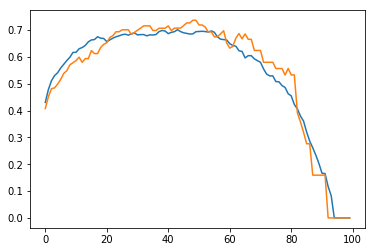

===== n_train = 1 =====
train result: (0.23, 0.7196064796858257)
val result: (0.54, 0.751709811252909)


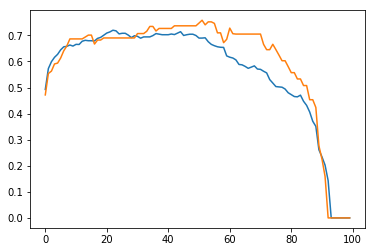

===== n_train = 2 =====
train result: (0.41000000000000003, 0.6992727674876579)
val result: (0.5, 0.7341430003606951)


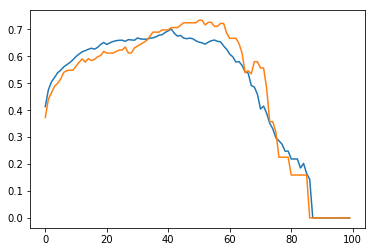

===== n_train = 3 =====
train result: (0.21, 0.7150321794126981)
val result: (0.49, 0.7436967984290958)


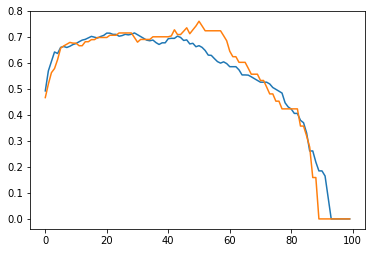

===== n_train = 4 =====
train result: (0.44, 0.7487441611896641)
val result: (0.5, 0.7809329797525736)


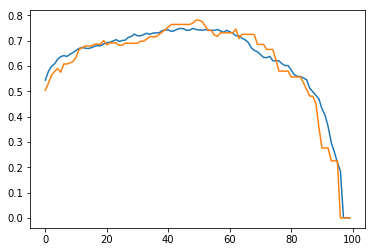

===== n_train = 5 =====
train result: (0.19, 0.7102952527805875)
val result: (0.47000000000000003, 0.7643574249945958)


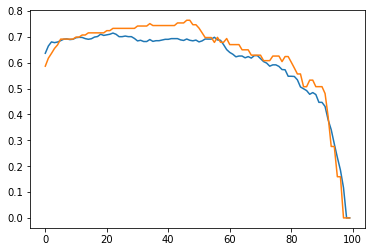

===== n_train = 6 =====
train result: (0.41000000000000003, 0.6986168132986839)
val result: (0.51, 0.79923720185168)


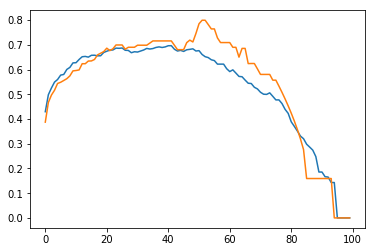

===== n_train = 7 =====
train result: (0.44, 0.6946259097677698)
val result: (0.53, 0.7758947879246116)


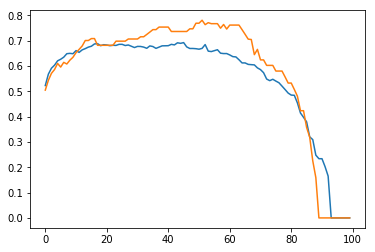

===== n_train = 8 =====
train result: (0.49, 0.7376643226251386)
val result: (0.44, 0.7578880825776165)


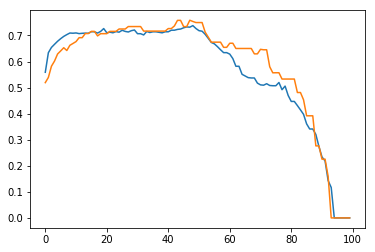

===== n_train = 9 =====
train result: (0.24, 0.6912146882972267)
val result: (0.48, 0.7818613084826256)


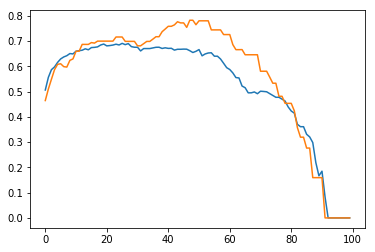

Beginning fold 2
===== n_train = 0 =====
train result: (0.44, 0.7567857858986253)
val result: (0.44, 0.6963418539524047)


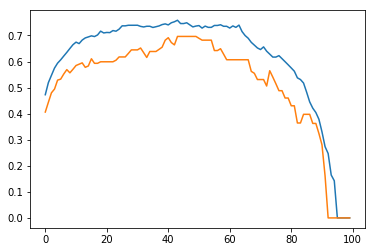

===== n_train = 1 =====
train result: (0.55, 0.7380781966320482)
val result: (0.41000000000000003, 0.6280730232565613)


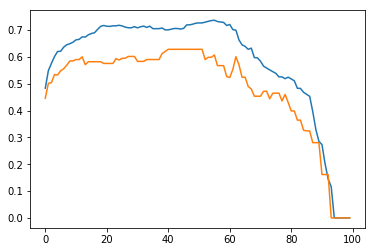

===== n_train = 2 =====
train result: (0.48, 0.7346562026532686)
val result: (0.48, 0.6850933056632622)


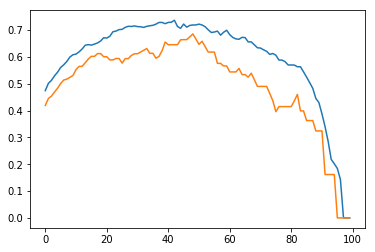

===== n_train = 3 =====
train result: (0.38, 0.7302463003798153)
val result: (0.53, 0.6755434603358206)


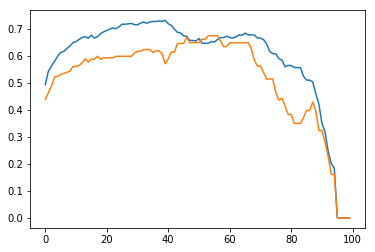

===== n_train = 4 =====
train result: (0.56, 0.7783203075736966)
val result: (0.51, 0.6818845587153387)


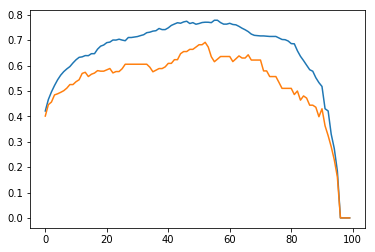

===== n_train = 5 =====
train result: (0.32, 0.74657790365525)
val result: (0.52, 0.6963418539524047)


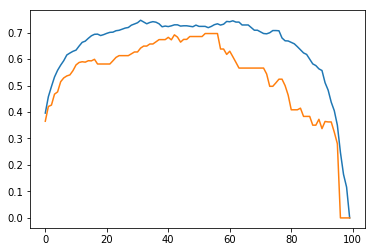

===== n_train = 6 =====
train result: (0.3, 0.7595169497680533)
val result: (0.49, 0.6540114857295032)


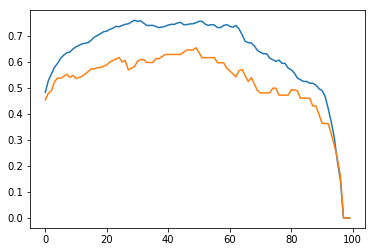

===== n_train = 7 =====
train result: (0.41000000000000003, 0.75342597117214)
val result: (0.58, 0.6555058578593557)


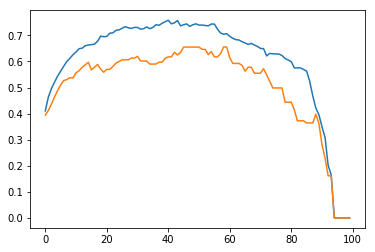

===== n_train = 8 =====
train result: (0.42, 0.7658212965022166)
val result: (0.42, 0.7014011906922292)


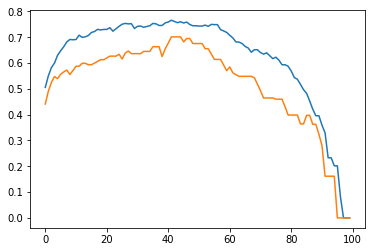

===== n_train = 9 =====
train result: (0.43, 0.7742575753080839)
val result: (0.5, 0.6498274783537379)


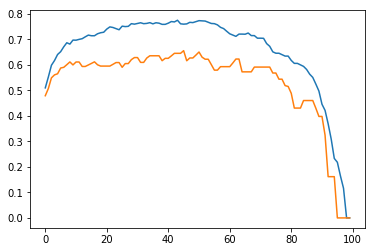

Beginning fold 3
===== n_train = 0 =====
train result: (0.44, 0.7659412026523458)
val result: (0.49, 0.797199496198485)


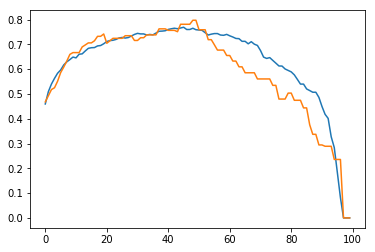

===== n_train = 1 =====
train result: (0.38, 0.7130052226773789)
val result: (0.14, 0.7058678542503619)


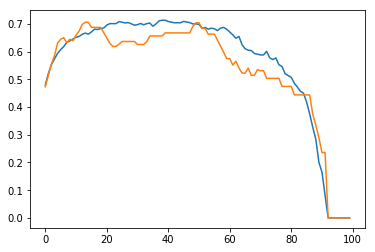

===== n_train = 2 =====
train result: (0.59, 0.7336489671829095)
val result: (0.49, 0.7509694645660066)


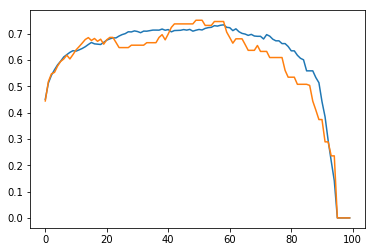

===== n_train = 3 =====
train result: (0.49, 0.7318302710672124)
val result: (0.39, 0.7624946152081027)


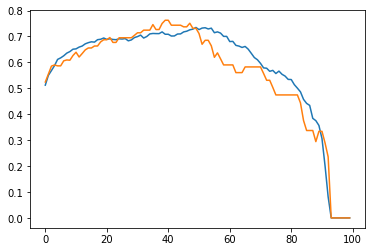

===== n_train = 4 =====
train result: (0.7000000000000001, 0.7557041159370474)
val result: (0.66, 0.7809620567888277)


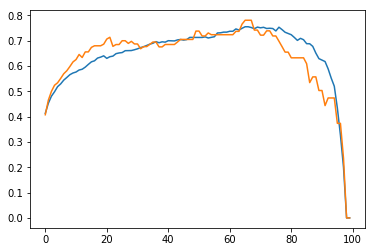

===== n_train = 5 =====
train result: (0.61, 0.7397359422678629)
val result: (0.41000000000000003, 0.7112025459827352)


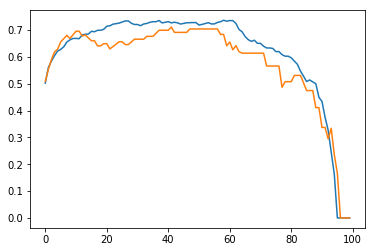

===== n_train = 6 =====
train result: (0.43, 0.781285411214282)
val result: (0.48, 0.7313358487597429)


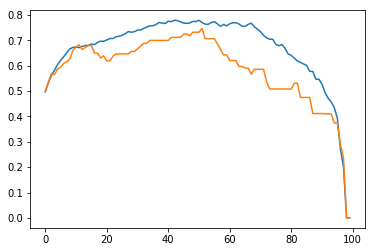

===== n_train = 7 =====
train result: (0.53, 0.7470659546319106)
val result: (0.4, 0.7112025459827352)


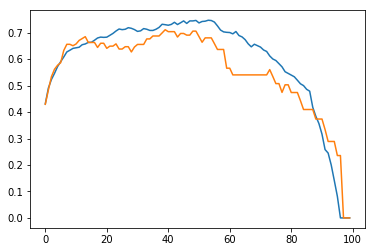

===== n_train = 8 =====
train result: (0.5, 0.7510475657085078)
val result: (0.49, 0.7461244938802352)


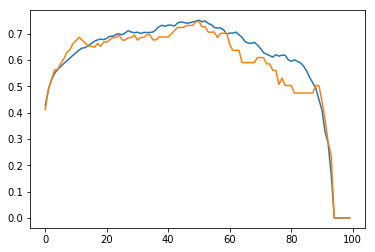

===== n_train = 9 =====
train result: (0.52, 0.7783282355907143)
val result: (0.49, 0.778233931865526)


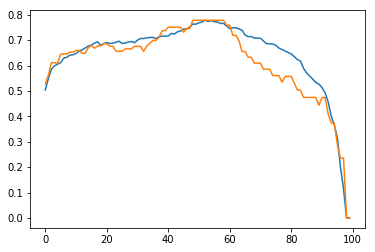

Beginning fold 4
===== n_train = 0 =====
train result: (0.5, 0.7206472605408776)
val result: (0.45, 0.7329406594546235)


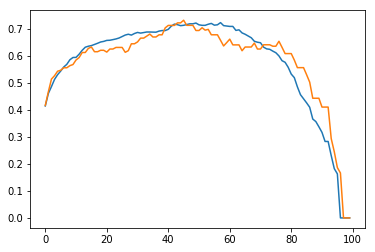

===== n_train = 1 =====
train result: (0.49, 0.7506807660281515)
val result: (0.5, 0.7140903725013398)


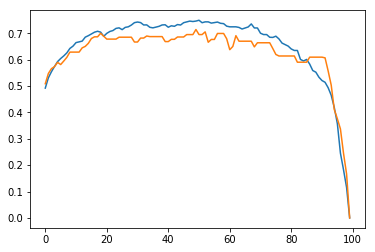

===== n_train = 2 =====
train result: (0.66, 0.7439004287979362)
val result: (0.53, 0.703011073410966)


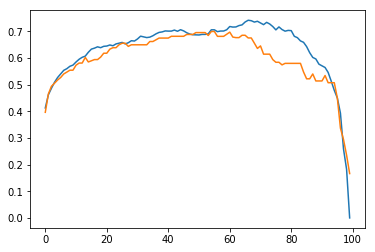

===== n_train = 3 =====
train result: (0.38, 0.7613865918316235)
val result: (0.47000000000000003, 0.7846242044439473)


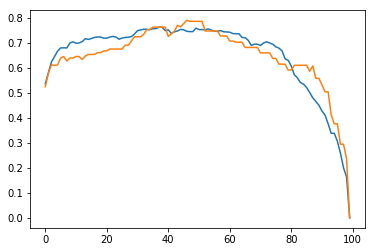

===== n_train = 4 =====
train result: (0.48, 0.7123087558445148)
val result: (0.49, 0.6756626675766066)


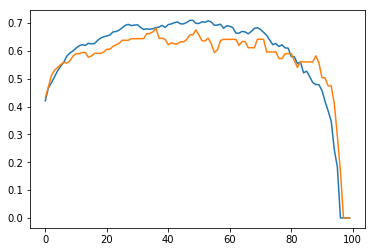

===== n_train = 5 =====
train result: (0.44, 0.7852564180481535)
val result: (0.44, 0.7846242044439473)


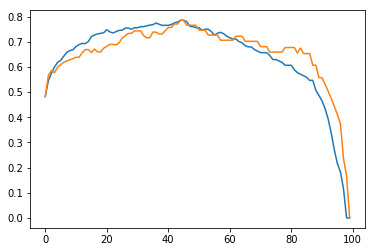

===== n_train = 6 =====
train result: (0.54, 0.7575851817473486)
val result: (0.5700000000000001, 0.7564427077306826)


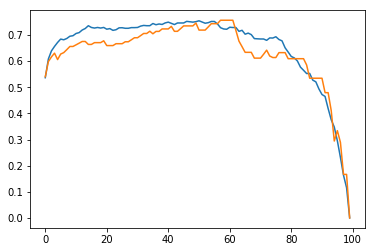

===== n_train = 7 =====
train result: (0.45, 0.7507406154313787)
val result: (0.41000000000000003, 0.707278370616979)


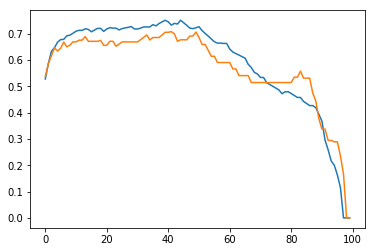

===== n_train = 8 =====
train result: (0.49, 0.7019491378101054)
val result: (0.5, 0.6857189725493567)


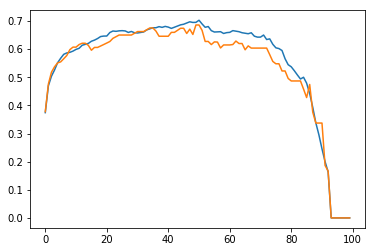

===== n_train = 9 =====
train result: (0.48, 0.7434503117368843)
val result: (0.47000000000000003, 0.7655542635324875)


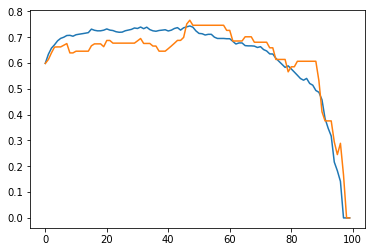

Beginning fold 5
===== n_train = 0 =====
train result: (0.55, 0.6784964825687867)
val result: (0.5700000000000001, 0.7828330911132553)


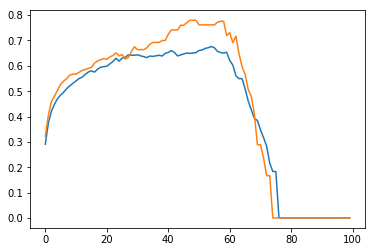

===== n_train = 1 =====
train result: (0.12, 0.7310733719993203)
val result: (0.47000000000000003, 0.7588353424924565)


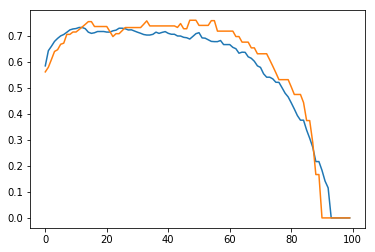

===== n_train = 2 =====
train result: (0.41000000000000003, 0.7134760991843144)
val result: (0.5, 0.7701692904873139)


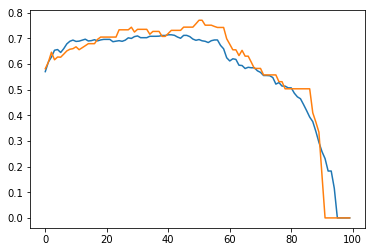

===== n_train = 3 =====
train result: (0.36, 0.741382161409789)
val result: (0.56, 0.81828556330392)


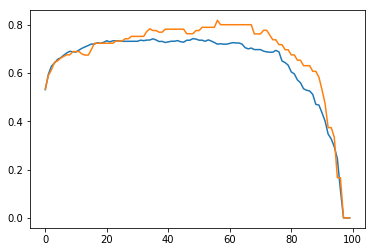

===== n_train = 4 =====
train result: (0.4, 0.7131051495528832)
val result: (0.55, 0.7809213616099598)


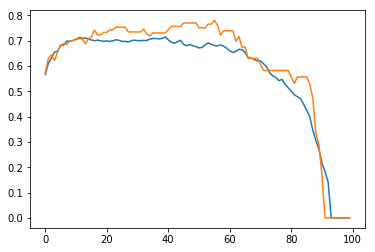

===== n_train = 5 =====
train result: (0.5, 0.6666346729334177)
val result: (0.46, 0.7535199577455783)


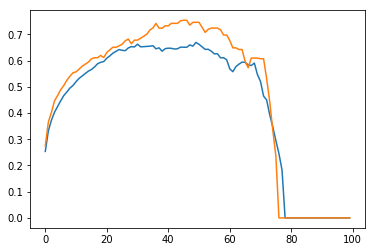

===== n_train = 6 =====
train result: (0.4, 0.6551643319917226)
val result: (0.49, 0.7874840959105226)


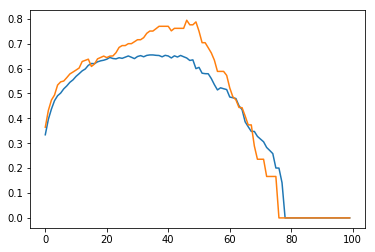

===== n_train = 7 =====
train result: (0.59, 0.6884080401649448)
val result: (0.49, 0.751466302364382)


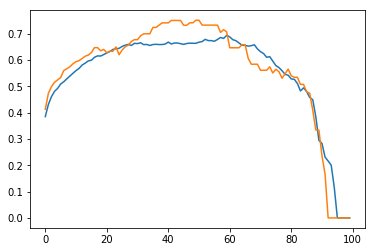

===== n_train = 8 =====
train result: (0.38, 0.6669962859507496)
val result: (0.44, 0.800970890875405)


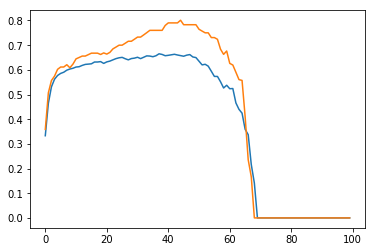

===== n_train = 9 =====
train result: (0.43, 0.6683047665643594)
val result: (0.5, 0.751466302364382)


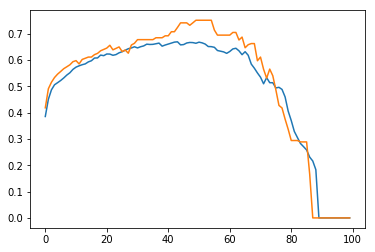

In [18]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for idx, (train_idx, val_idx) in enumerate(splits):
    print("Beginning fold {}".format(idx+1))

    for n_train in range(N_TRAIN):
        print(f"===== n_train = {n_train} =====")
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))
        plot_score(train_y, preds_train)
        plot_score(val_y, preds_val)
        plt.show()

#### (n_train)単位で結果を出力

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.48, 0.7365323413840272)
fold1 result: (0.44, 0.6963418539524047)
fold2 result: (0.49, 0.797199496198485)
fold3 result: (0.45, 0.7329406594546235)
fold4 result: (0.5700000000000001, 0.7828330911132553)
val result: (0.49, 0.7405103017585343)
===== n_train = 1 =====
fold0 result: (0.54, 0.751709811252909)
fold1 result: (0.41000000000000003, 0.6280730232565613)
fold2 result: (0.14, 0.7058678542503619)
fold3 result: (0.5, 0.7140903725013398)
fold4 result: (0.47000000000000003, 0.7588353424924565)
val result: (0.5, 0.7036425202681883)
===== n_train = 2 =====
fold0 result: (0.5, 0.7341430003606951)
fold1 result: (0.48, 0.6850933056632622)
fold2 result: (0.49, 0.7509694645660066)
fold3 result: (0.53, 0.703011073410966)
fold4 result: (0.5, 0.7701692904873139)
val result: (0.5, 0.715047549806439)
===== n_train = 3 =====
fold0 result: (0.49, 0.7436967984290958)
fold1 result: (0.53, 0.6755434603358206)
fold2 result: (0.39, 0.7624946152081027)
fold3 result: (0.47000000000000003, 0.

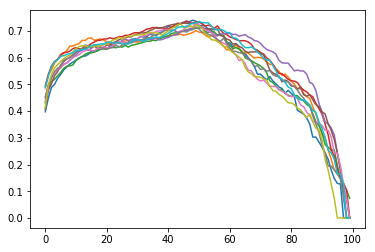

In [19]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)

    print("val result:", threshold_search(y_val, preds_val_all))
    plot_score(y_val, preds_val_all)

### adversarial validation

In [20]:
ad_result = pd.read_csv("./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0").sort_values("idx")
ad_val_idx = ad_train.query("preds > 0.75").idx.values
len(ad_val_idx)

303

In [21]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    val_idx_list = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        val_idx_list.append(val_idx)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)
    val_idx_list = np.concatenate(val_idx_list)
    
    result_df = []
    for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
        result_df.append((idx, target, preds))
    result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
    result_df = result_df.sort_values("idx").reset_index(drop=True)
    extract = result_df.query("idx in @ad_val_idx")

    print("val result:", threshold_search(y_val, preds_val_all))
    print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.48, 0.7365323413840272)
fold1 result: (0.44, 0.6963418539524047)
fold2 result: (0.49, 0.797199496198485)
fold3 result: (0.45, 0.7329406594546235)
fold4 result: (0.5700000000000001, 0.7828330911132553)
val result: (0.49, 0.7405103017585343)
adverl result: (0.4, 0.6371022126227242)
===== n_train = 1 =====
fold0 result: (0.54, 0.751709811252909)
fold1 result: (0.41000000000000003, 0.6280730232565613)
fold2 result: (0.14, 0.7058678542503619)
fold3 result: (0.5, 0.7140903725013398)
fold4 result: (0.47000000000000003, 0.7588353424924565)
val result: (0.5, 0.7036425202681883)
adverl result: (0.2, 0.5461012725852327)
===== n_train = 2 =====
fold0 result: (0.5, 0.7341430003606951)
fold1 result: (0.48, 0.6850933056632622)
fold2 result: (0.49, 0.7509694645660066)
fold3 result: (0.53, 0.703011073410966)
fold4 result: (0.5, 0.7701692904873139)
val result: (0.5, 0.715047549806439)
adverl result: (0.56, 0.5945729467579597)
===== n_train = 3 =====
fold0 result: (0.49, 0.74369679842909

### predict v3

- 全ての(idx, fold)をsigmoidにスケール変換
- 足し合わせて閾値を決める

In [39]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        calb = _SigmoidCalibration()
        calb.fit(preds_val, val_y)
        preds_val = calb.predict(preds_val)
        preds_test = calb.predict(preds_test)
        preds_val_idx += preds_val / N_TRAIN
        preds_test_idx += preds_test / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.52, 0.7673983347707652)
(0.41000000000000003, 0.6772361621358955)
(0.54, 0.7617303562939804)
(0.42, 0.7461008407836195)
(0.63, 0.7971630474324247)
val result: (0.38, 0.728210997113812)


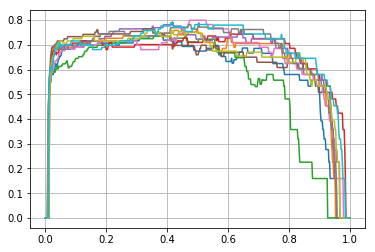

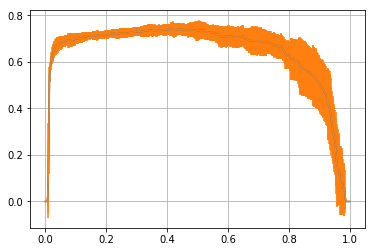

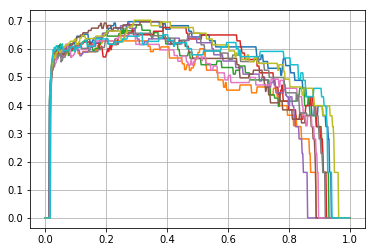

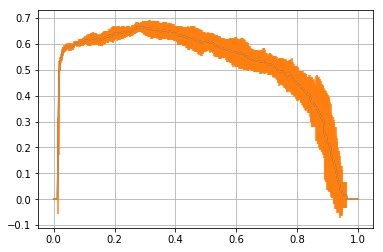

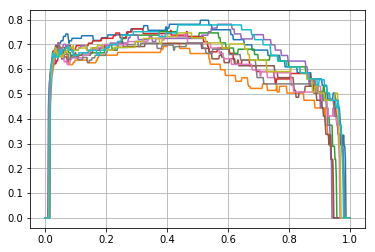

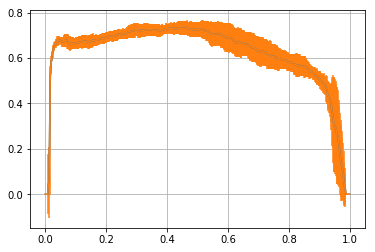

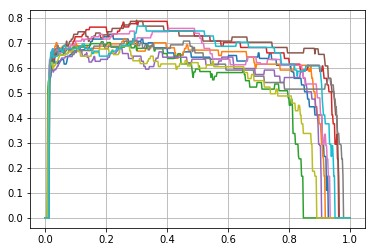

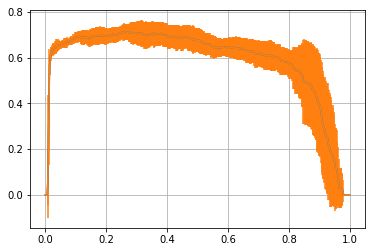

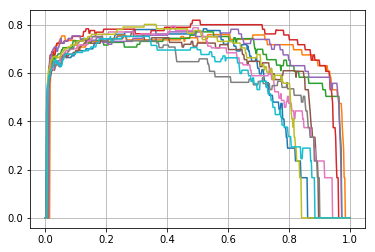

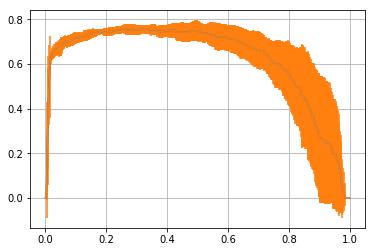

In [40]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

In [41]:
thr = 0.33
preds_test_sub = np.zeros(len(X_test_input))
for idx, (train_idx, val_idx) in enumerate(splits):
    preds_test_idx = preds_test_all[idx]
    preds_test_sub += preds_test_idx / len(splits)
    
preds_test_sub = (preds_test_sub > thr).astype(int)
preds_test_sub.sum()

293

In [42]:
pred_3 = []
for pred_scaler in preds_test_sub:
    for i in range(3):
        pred_3.append(pred_scaler)
sub = np.squeeze(pred_3)
sub.sum()

879

In [43]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = sub
submission['target'] = submission['target'].astype(int)
submission.to_csv(save_dir + 'submission_v3.csv', index=False)
submission.sum()

signal_id    383962560
target             879
dtype: int64